# Bark Beetles: Predicting the Plague - Model Training

#### Modeling the spruce bark beetle infestation in short-time intervals for locally distinct spatial administrative units within Saxony on the basis of the infestation development and the weather pattern up to the time of forecast

**Abstract**
In this notebook sets of regression models for the amount of infested wood are fitted. The models make predictions for one timeframe, one forestry district and for one ownership group at a time (analogous to the dataset structure). Multiple approaches are compared, their models evaluated and the most appropriate model chosen for deployment. Even though only three sets of models were trained, each during a different approach, many more models and combinations of features were tested in the course of this project.

# 1 Setup

In [5]:
# imports 
import numpy as np
import pandas as pd
import plotnine as p9
import pickle
from matplotlib import rcParams
import warnings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV)
from sklearn.model_selection import (
    cross_val_predict, cross_val_score, cross_validate)
from sklearn.metrics import (
    mean_squared_error, explained_variance_score, mean_absolute_error)
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor)
from xgboost import XGBRegressor

# settings
warnings.filterwarnings('ignore')
# diplay all columns of a dataframe
pd.options.display.max_columns= None

# set default font (used in p9.theme_seaborn())
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']

# defining custom colors, used whenever possible to match presentation
mycolors = ['#447672', '#ee6d71', '#8fc0e0', '#ffb947', 
            '#4e445f', '#d1d882', '#9D7558', '#a7d8d4', 
            '#ffaeac', '#b0b7bd', '#fce4c9', '#bfb4d2', 
            '#5b83a8', '#575757']

# make custom plotnine theme
mythemewide = (p9.theme_seaborn() 
             + p9.theme(
                 rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
                 panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
                 strip_text=p9.element_text(size=14),
                 text=p9.element_text(size=17),
                 figure_size = (15, 7.5),
                 subplots_adjust={'hspace': 0.31, 'wspace': 0.31}
             )
            )

In [6]:
# read dataset
data = pd.read_csv('barkbeetle_dataset.csv')

# reestablish timestamps
data['timestamp'] = pd.to_datetime(data['timestamp'])

# remove pre 2006 and post feb2020 
data = data[data['timestamp'].isin(
    pd.date_range(start='2006-01-01', end='2020-02-29', freq='M')
)]

# 2 Preparing the training and evaluation functions

To allow for a simple and clear training process, steps that are performed several times will be defined preemptively in this chapter. In the following chapters different approaches for models will be carried out, all of which will call these functions in the same manner.

## 2.1 Preparation of data for pipelines

Some steps (transformations/truncation) need to be performed on the data before the actual training can take place.

One of these steps is to take the different training/test/validation sets and remove (as well as lock away) the 'id' and 'timestamp' features, as we do NOT want to use these in model training but still need them to plot and evaluate the results. Remember that 'id' feature was originally created to allow for the allocation and assignment of the other features to the respective forestry districts and ownership groups in a unique identifier. The 'timestamp' is used to chronological represent the features as a time series.

A second function is used to encode the different months of the timeframe feature - the categorical feature is converted a numeric one. During the EDA the timeframe was established as having a significant impact on the amount of infested wood. However leaving this feature as a categorical would mean using dummy variables for the different months which is unnecessary as well as inefficient. This is why a single numerical feature is used. This new feature indicates how much of the total infested wood is accumulated on average in the respective month(s) that the observation is from. All eight timeframes get assigned a float representing the percentage of yearly infested wood that is observed on average in the respective timeframe in the training set. These floats are then used to denote the timeframes instead of the categorical representation. It is important that only the training set is used to calculate this new feature because it contains knowledge about the target variable. We do not want information to leak from the test/validation set into our features and model, so only using the training set values is paramount.  

In [7]:
def results_setup(X_train, X_val, X_test, y_train, y_val, y_test):    
    '''
    Function to remove and save ids and timestamps from the data sets and 
    collect them in a combined dataframe. This dataframe can be used to later 
    show the model predictions.
    
    inputs:
        - X_train, X_val, X_test: training, validation and test set features
        - y_train, y_val, y_test: training, validation and test set targets
    returns:
        - a dataframe with the ids, timestamps and target variable values
          of the different data sets as well as a column denoting the 
          observation origin
    '''
    
    # remove and save ids and timestamps from the sets
    id_train, ts_train = X_train.pop('id'), X_train.pop('timestamp')
    id_val, ts_val = X_val.pop('id'), X_val.pop('timestamp')
    id_test, ts_test = X_test.pop('id'), X_test.pop('timestamp')
    
    # create dataframe with this information
    results_df = pd.concat([X_train, X_val, X_test])
    results_df['id'] = pd.concat([id_train, id_val, id_test])    
    results_df['timestamp'] = pd.concat([ts_train, ts_val, ts_test])
    results_df['true value'] = pd.concat([y_train, y_val, y_test]) 
    
    results_df['set'] = ['train set'] * X_train.shape[0] \
    + ['validation set'] * X_val.shape[0] + ['test set'] * X_test.shape[0]
    
    return results_df

In [8]:
def month_num_encoder(X_train, y_train, X_val, X_test):
    '''
    This function converts the timeframe feature of all input sets into a 
    numerical one via assignment of the average percentage the target variable
    value of the respective months in the training set.
    
    inputs:
        - X_train, X_val, X_test: training, validation and test set features
        - y_train: training set targets
    returns:
        - the training, validation and test sets with converted timeframes
    '''
        
    # get a factor for every timeframe that represents how much of the yearly 
    # infestation was observed in the respective timeframe (training set only)
    
    # merge timeframe column from X_train with y_train (target)
    tf_y = pd.DataFrame({'timeframe': X_train['timeframe'], 'target': y_train})
  
    # group by timeframe and take the mean of target
    tf_y = tf_y.groupby('timeframe').mean()
    
    # get the sum of all groups
    total = tf_y['target'].sum()
    
    # make a dictionary that maps the timeframe to the factor values
    transform_dict = tf_y['target'].map(lambda x: x/total).to_dict()

    # use these factors as a single numerical feature in all sets instead of the 
    # old timeframe feature (categorical with 8 categories)
    # since only targets of train set were used in calculation: no data leakage 
    
    new_X_train = X_train.copy()
    new_X_train['timeframe'] = new_X_train['timeframe'].map(
        lambda x: transform_dict.get(x)
    )
    new_X_train.columns = [
        'timeframe_enc' if x=='timeframe' else x for x in new_X_train.columns
    ]
    
    new_X_val = X_val.copy()
    new_X_val['timeframe'] = new_X_val['timeframe'].map(
        lambda x: transform_dict.get(x)
    )
    new_X_val.columns = [
        'timeframe_enc' if x=='timeframe' else x for x in new_X_val.columns
    ]
    
    new_X_test = X_test.copy()
    new_X_test['timeframe'] = new_X_test['timeframe'].map(
        lambda x: transform_dict.get(x)
    )
    new_X_test.columns = [
        'timeframe_enc' if x=='timeframe' else x for x in new_X_test.columns
    ]
    
    return new_X_train, new_X_val, new_X_test

## 2.2 Fitting the pipelines

The next set of functions is used to get the crossvalscores of the initial pipelines that will be created and fit them according to a specified hyperparameter grids.

In [9]:
def crossvalscores(pipelines, X_train, y_train):
    '''
    Make predictions on the training set using cross validation and 
    print results. 
    
    inputs:
        - pipelines: list with different model pipelines
        - X_train: training set features
        - y_train: training set targets
    '''
    
    for pipe in pipelines:
        print(f'Cross validation scores for {pipe.steps[-1][1]}:')
        # cross_val_predict expects an estimator (model), X, y and 
        # number of cv-splits (cv)
        y_train_predicted = cross_val_predict(pipe, X_train, y_train, cv=5)
        
        # calculating the mean absolute error
        mae = mean_absolute_error(y_train, y_train_predicted)
        
        # calculating the root mean squared error 
        rmse = mean_squared_error(y_train, y_train_predicted, squared=False)
        
        # calculating the explained variance 
        ev = explained_variance_score(y_train, y_train_predicted)
        
        # print results
        print('-------------------------')
        print(f'MAE: {mae:.2f}')
        print(f'RMSE: {rmse:.2f}')
        print(f'Explained Variance: {ev:.2f}')
        print('\n')

In [10]:
def randomsearchcv(grids, grid_dict, X_train, y_train, X_val, y_val):
    '''
    Perform a randomized cross-validated search on hyperparameters. Then fit
    and return the best model and print evaluation metrics.
    
    input:
        - grids: list of sklearn.model_selection.RandomizedSearchCV objects to
          be fitted, including hyperparameter grid
        - grid_dict: dictionary with keys denoting the order of execution 
          (= order of 'grids' list) and regressor names as values 
        - X_train, X_val: training and validation set features
        - y_train, y_val: training and validation set targets
        
    returns:
        - a dictionary with the best models of each regressor, keys analogous 
          to grids and grid_dict
    '''
    
    # Fit the grid search objects
    print('Performing model optimizations...')
    
    # variable for best mae and emtpy dictionary for best models
    best_mae = np.inf
    best_models = {}
    
    for idx, rs in enumerate(grids):
        # print name of current regressor
        print(f'\nEstimator: {grid_dict[idx]}')	
        
        # Fit grid search	
        rs.fit(X_train, y_train)
        
        # Best params
        print(f'Best params: {rs.best_params_}')
        
        # Best training data accuracy
        print(f'Best training MAE: {-rs.best_score_:.2f}') 
        
        # Predict on validation data with best params
        best_model = rs.best_estimator_    
        y_val_pred = best_model.predict(X_val)
        
        # Validation data MAE of model with best params
        mae_val = mean_absolute_error(y_val, y_val_pred)
        print(f'Validation set MAE for best params: {mae_val:.2f}')
        
        # save best model in best_models
        best_models[idx] = best_model
        
        # Independently track best model (highest MAE) across all estimators
        if mean_absolute_error(y_val, y_val_pred) < best_mae:
            best_mae = mean_absolute_error(y_val, y_val_pred)
            best_rs = rs
            best_reg = idx
    
    # print summary of the best models for every regressor type
    for idx, model in best_models.items():
    
        y_val_pred = model.predict(X_val)
        print(f'\n\nSummary of validation set errors')
        print(f'{grid_dict.get(idx)}:')
        print('-------------------------')
        
        # calculating the mean absolute error
        mae = mean_absolute_error(y_val, y_val_pred)
        
        # calculating the root mean squared error 
        rmse = mean_squared_error(y_val, y_val_pred, squared=False)
        
        # calculating the explained variance 
        ev = explained_variance_score(y_val, y_val_pred)
        
        # print results
        print(f'MAE: {mae:.2f}')
        print(f'RMSE: {rmse:.2f}')
        print(f'Explained Variance: {ev:.2f}\n')
    
    # Best overall regressor
    print(f'\nRegressor with best validation set MAE: {grid_dict[best_reg]}')
    
    return best_models

## 2.3 Model Evaluation

The last function covers plotting of the results and evaluation of the models. Three evaluation metrics are compared regarding training and validation set for the best models of each regressor type. Then the predictions of the best model and actual values are compared in a time series plot for every combination of forestry district and forest ownership group (= every ID). Four representative plots from among them are shown and the rest written to disk. Furthermore, feature importances are also plotted for the appropiate regressors. 

In [46]:
def plot_results(results_df, best_models, grid_dict, 
                 X_train, X_val, y_train, y_val, path):
    '''
    Function for creating appropriate evaluation plots. Creates plots 
    concerning the evaluation metrics, the comparison of actual and predicted
    values as well as feature importances.
   
    inputs:
        - results_df: dataframe with ids, timestamps and target variable values 
          of the different data sets as created by results_setup() function
        - best_models: dictionary with best models for each regressor type as
          created by randomsearchcv() function
        - grid_dict: dictionary with keys analogous to best_models and values
          with the regressor names 
        - X_train, X_val: training and validation set features
        - y_train, y_val: training and validation set targets
        - path: string with the directory path to save figures in
    '''
    # 1.) Plot evaluation metrics of train/val sets for best models
    
    # first, remove from results_df all test set values, as the test set will
    # only be examined after final model is chosen
    results_df = results_df[
        results_df['set'] != 'test set'
    ].reset_index(drop=True)
    
    # empty list where evaluation metrics will be saved
    scores = []
    
    # iterate over best models = different regressors
    for idx, model in best_models.items():
        
        # regressor name
        name = grid_dict.get(idx)
        
        # model predictions
        y_val_pred = model.predict(X_val) 
        y_train_pred = model.predict(X_train)
        
        # save the predictions so they can be compared in a plot
        results_df[name] = np.concatenate([y_train_pred, y_val_pred])
        
        # append scores list with evaluation metrics
        scores.append([name, 
                       mean_absolute_error(y_train, y_train_pred),
                       mean_squared_error(y_train, y_train_pred, squared=False),
                       explained_variance_score(y_train, y_train_pred),
                       'training set'
                      ])
            
        scores.append([name, 
                       mean_absolute_error(y_val, y_val_pred),
                       mean_squared_error(y_val, y_val_pred, squared=False),
                       explained_variance_score(y_val, y_val_pred),
                       'validation set'
                      ])
    # convert scores to dataframe 
    scores = pd.DataFrame(scores, columns=[
        'model', 
        'Mean Absolute Error', 
        'Root Mean Squared Error', 
        'Explained Variance', 
        'set'
    ])
    
    # plot comparison of model scores
    # melt scores as plotnine likes long data format
    draw = pd.melt(scores, id_vars=['model','set'])
    
    # plot scores
    s = (
        p9.ggplot(draw)
        + p9.geom_col(p9.aes('set', 'value', fill='model'), position='dodge')
        + p9.facet_wrap('variable', scales='free_y')
        + p9.scale_fill_manual(mycolors[:5])
        + p9.ylab('metric value') + p9.xlab('')
        + mythemewide
    )
    # show plot
    s.draw()
    # save plot
    s.save(fr'{path}scores.png', verbose=False)
    
    ###########################################################################  
    
    # 2.) Plot predictions
    
    # make list with best models, sorted by validation set MAE (primary metric)
    top_models = list(
        scores[scores['set'] == 'validation set'].sort_values(
            'Mean Absolute Error', ascending=True
        )['model']
    )
    
    # choose a subset of representative ids 
    # only plots of these ids will be shown in notebook
    id_subset = [
        'Vogtlandkreis-Schöneck-SW',
        'Sächsische Schweiz-Osterzgebirge-Sebnitz-NSW',
        'Erzgebirgskreis-Zwönitz-NSW',
        'Kreisfreie Stadt Dresden-Dresden-SW'
    ]
    
    # make plot for every ID
    for ID in results_df['id'].unique():
        
        draw = results_df[results_df['id'] == ID]
        # melt data
        # only plot the predictions of the best model to keep readability
        draw = pd.melt(draw, id_vars=['id', 'timestamp', 'set'], 
                       value_vars=['true value', top_models[0]])
        
        # highlight which observations are from the validation set 
        validation_ts = draw[draw['set'] == 'validation set']['timestamp']
        
        # plot predictions
        p = (
            p9.ggplot(draw)
            + p9.geom_vline(xintercept=validation_ts, color=mycolors[0], 
                            size=.3, linetype='dashed', alpha=1)
            + p9.geom_line(p9.aes('timestamp', 'value', color='variable'))
            + p9.scale_color_manual([mycolors[1], 'black'], 
                                    name='model')
            + p9.xlab('date') + p9.ylab(r'infested wood in solid m$^3$')
            + p9.labels.ggtitle(ID)
            + mythemewide
        )
        # save plot
        p.save(fr'{path}{ID}.png', verbose=False)
        
        # only show plots for IDs in subset_id
        if ID in id_subset:
            p.draw()
            
    ########################################################################### 
    
    # 3.) Feature importances
    
    # empty dictionary for feature importances
    importances = {}
    
    # iterate over best models = different regressors
    for idx, model in best_models.items():
        
        # feature importances are only appropriate for certain regressors
        if type(best_models[idx]['regressor']) in [
            type(XGBRegressor()), 
            type(RandomForestRegressor()), 
            type(GradientBoostingRegressor())
        ]:
            importances[idx] = model['regressor'].feature_importances_
        
        # for linear regression the coefficients are roughly equivalent 
        elif type(model['regressor']) == type(LinearRegression()):
            importances[idx] = abs(model['regressor'].coef_)
        
        # for other regressors (such as KNeighbors-Regression) no importance
        else:
            continue
        
        # account for dimension reduction via PCA 
        if type(model[1]) == type(PCA()):
            # reduced features have no names, instead use auto-numbering
            importances_names = None
        else:
            importances_names = X_train.columns

    # melt data as plotnine likes long format
    draw = pd.melt(pd.DataFrame(
        list(importances.values()), 
        columns=importances_names, 
        index=[grid_dict.get(idx) for idx in importances.keys()]), 
        ignore_index=False)
    
    # plot importances
    i = (
        p9.ggplot(
            p9.aes('reorder(variable, -value)', 'value', fill=draw.index),
                  data=draw)
        + p9.geom_col(position='dodge')
        + p9.scale_fill_manual([mycolors[0], mycolors[2], mycolors[4]], name='model') # each color manually so they match the other plots
        + p9.xlab('feature') + p9.ylab('importance')
        + mythemewide
        + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
    )
    # show plot
    i.draw()
    # save plot
    i.save(fr'{path}importances.png', verbose=False)

# 3 Linear Regression as a Baseline

Creating some sort of baseline model is common practise in machine learning. In the case of this project linear regression is chosen as a baseline to which the other models are compared (in contrast to a general tendency measure, such as the median or mean). So in this chapter the modeling is executed not with several pipelines including different regressors but only one pipeline with a linear Regression and no hyperparameter tuning.

## 3.1 Feature selection

For the linear regression approach the most promising features examined during EDA are selected. They include the endangered forest area as a proxy for the forestry district, the timeframe of the observation, three largely independent measures of the previous infested wood (previous observation in the same forestry district and ownership group, the sum of previous infested wood for the last year in this forestry district and ownership group, previous observation in the OTHER forest ownership group in the same forestry district), the corrected waterbalance of the current timeframe as well as a rollwing mean of the last 6 summer months and finally the last reported figure for the demolition wood.

In [12]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[[
    # timestamp, id included only to structure results, not used in training
    'timestamp', 'id', 
    'area_endangered', 'timeframe',
    'prev_infested_wood', 'prev_infested_wood_rollyr', 
    'prev_infested_wood_ofo',
    'KWK', 'KWK_rollsr',
    'demolition_wood'
]]


## 3.2 Train-val-test split

After feature selection, the train-val-test split takes place. The data set is split with a ratio of 80%-10%-10%. The train set is then used to train the different models (with cross-validation). The validation set is used in hyperparameter tuning (though not applicable for linear regression) and to evaluate the models as well as chose the best one via evaluation metrics. The test set is not touched or examined until after the final model is chosen. Then it will be used to get an impression on how the model performs on new and unseen data. It is important that no data leakage from the different sets takes place and that no information from the test set affects how the models are fitted and chosen. One way to assure this is to use sklearns pipelines in combination with the functions created in previous chapters where extra attention was paid to this phenomenon.

In [13]:
# specify ratops
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# make train set according to train_ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=1 - train_ratio 
)

# make validation and test set according to val_ratio and test_ratio
# shuffle already done in first split
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, random_state=0, shuffle=False,
    test_size=test_ratio / (test_ratio + val_ratio) 
)  

# Show the results of the split
print (f'Training set has {X_train.shape[0]} samples.')
print (f'Validation set has {X_val.shape[0]} samples.')
print (f'Testing set has {X_test.shape[0]} samples.')

Training set has 9515 samples.
Validation set has 1189 samples.
Testing set has 1190 samples.


## 3.3 Preparations

The functions from chapter 2.1 are used to prepare the data for model training. This includes setting up the results dataframe while removing ids and timestamps from the data and the conversion of the categorical timeframe feature into a numeric one with only the knowlegde of the targets from the training set.

In [14]:
# remove id and timestamp and set up results dataframe
base_results_df = results_setup(X_train, X_val, X_test, y_train, y_val, y_test)

In [15]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

In [16]:
# final look at data before feeding it into the pipelines for training
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_endangered            9515 non-null   float64
 1   timeframe_enc              9515 non-null   float64
 2   prev_infested_wood         9513 non-null   float64
 3   prev_infested_wood_rollyr  9500 non-null   float64
 4   prev_infested_wood_ofo     9513 non-null   float64
 5   KWK                        9515 non-null   float64
 6   KWK_rollsr                 9502 non-null   float64
 7   demolition_wood            9511 non-null   float64
dtypes: float64(8)
memory usage: 669.0 KB


## 3.4 Pipeline Setup

As was discussed earlier, sklearn pipielines are used to transform and fit the models to the data. They allow for a clear model fitting and the hyperparameter tuning process and ensure that the data sets are handled correctly, preventing data leakage and making the final model, which will be written to a file, easier to use for predictions in teh future. We will start with the creation of imputer and scaling steps. In later chapters for more complex models, different pipelines will be used for different regressors and a custom hyperparameter search is executed.

First, let's check what numerical and categorical features we have.

In [17]:
# Creating list for categorical predictors/features 
cat_features = list(X_train.columns[X_train.dtypes==object])
print(f'Categorical features: {cat_features}')

# Creating list for numerical predictors/features
num_features = list(X_train.columns[X_train.dtypes!=object])
print(f'Numerical features: {num_features}')

Categorical features: []
Numerical features: ['area_endangered', 'timeframe_enc', 'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo', 'KWK', 'KWK_rollsr', 'demolition_wood']


As also seen in chapter 3.3 we do not have any categorical features anymore, as the timeframe feature was converted to a numerical one. Since the data science life cylce is traversed in an iterative fashion and in the future we might also directly include the forestry districts or counties (although not currently planned), we will create one imputer for numerical features and one for categorical features. The numerical features will also be scaled with sklearns standard scaler, for the categorical features dummy variables will be created one-hot-encoding.

In [18]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()) 
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

The pipeline is completed with a linear regression model and the 'grid_dict' and 'pipelines' objects are created according to the specifications of our evaluation functions.

In [19]:
# Building a full pipeline with our preprocessor and a regressor
pipe_base = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
])

pipelines = [pipe_base]
grid_dict = {0: 'Linear Regression'}

## 3.5 Model Training

As the data is now prepared and the pipelines are specified, we can begin with the fitting of the baseline models. Again, there is no hyperparameter search in this step, so we will simply print the cross-validation scores for the linear regression model and look at the results.

In [20]:
crossvalscores(pipelines, X_train, y_train)

Cross validation scores for LinearRegression(n_jobs=-1):
-------------------------
MAE: 288.15
RMSE: 1573.32
Explained Variance: 0.56




In [21]:
base_model = {0: pipe_base.fit(X_train, y_train)}

## 3.6 Model Evaluation

The primary evaluation metric for this project is the mean absolute error (MAE). As was established during the EDA, the target variable distribution is heavily skewed to the left with the majority of values falling between zero and 100 while values up to 114,000 also exist within the data. These high values are observed exclusively in the last few years (2018 and onward) and they are the main driver for this project in the first place. However we still want the model the generalize well and to meaningfully learn from the vast majority of values of the years previous to 2018. If the models are scored and optimized for MAE, all observations are taken into account roughly equivalent to their absolute values. An observatoin with a target value of 100,000 is more important than an observation with a target value of 100, which is what we want. However, if a metric like the mean squared error (MSE) is chosen, instead errors are penalized regarding their squares. So this difference in magnitude is amplified even further to an extraordinary amount, which likely contributes to the creation of model that does not generalize well and may 'disregard' low target values. This, as well a more intuitive interpretation of the metric, is why the MAE was chosen as the primary evaluation metric.  

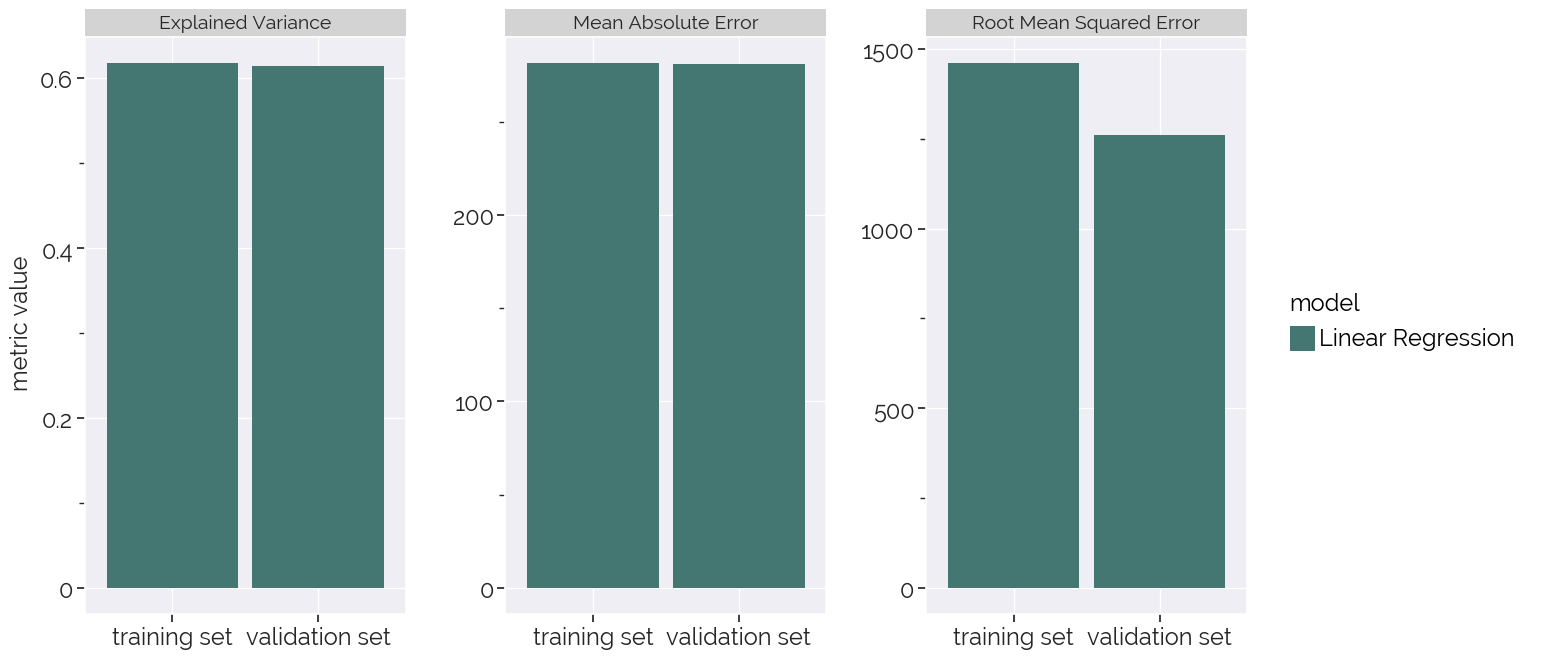

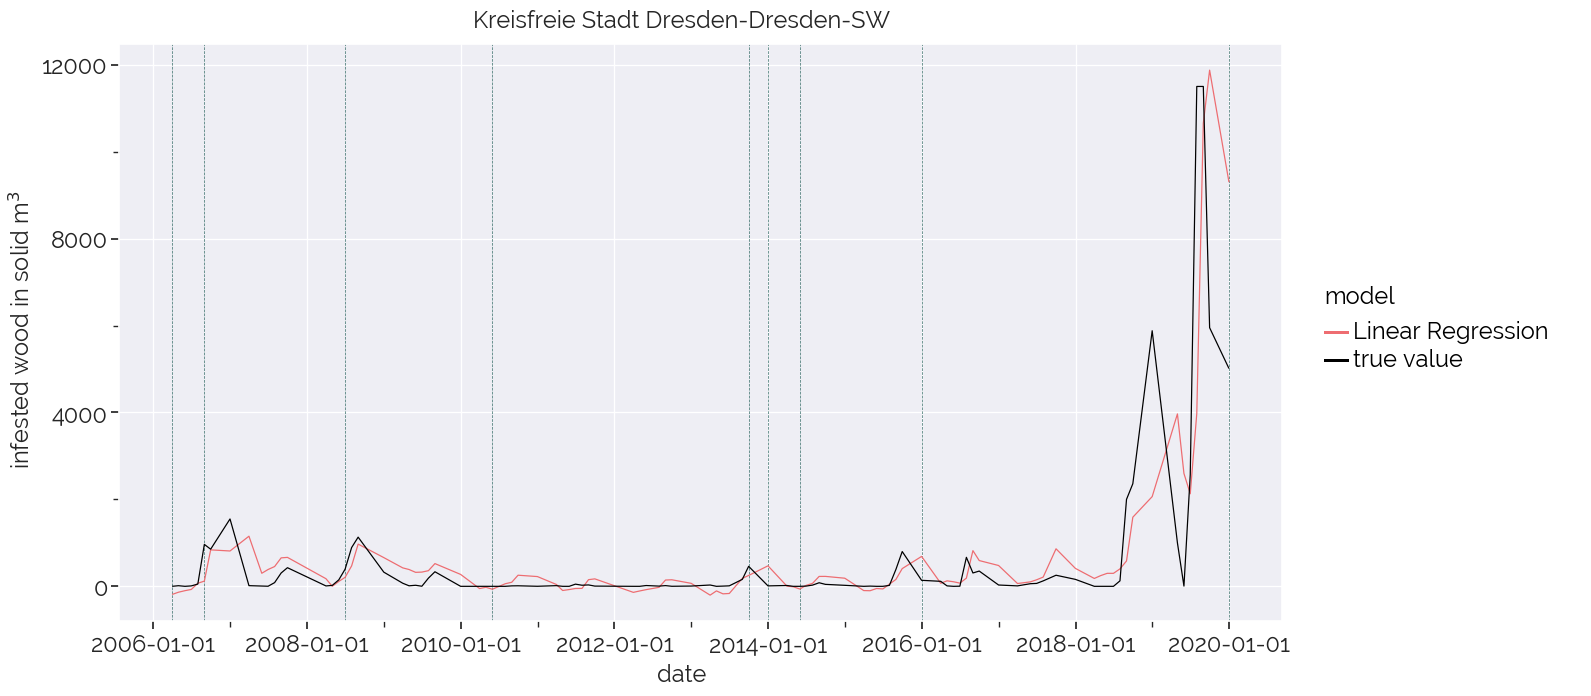

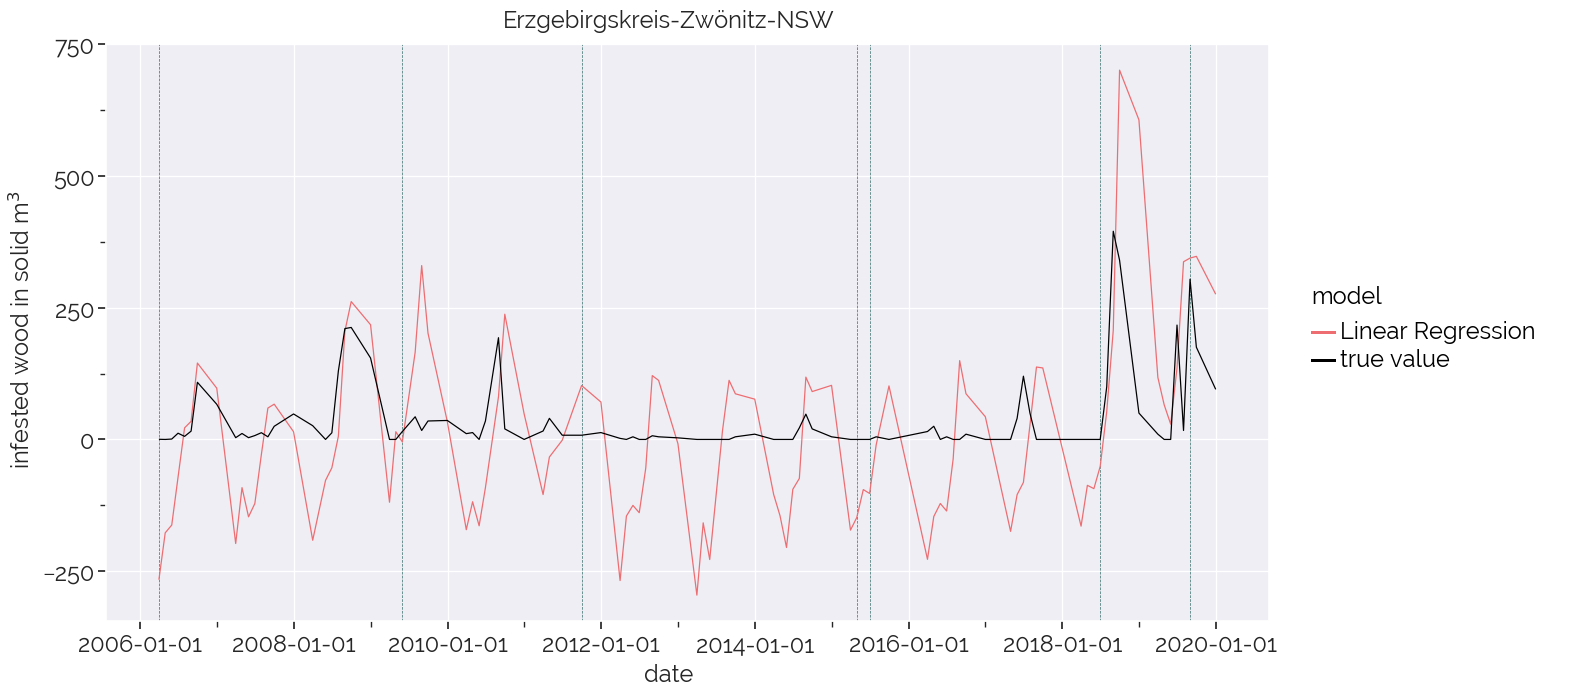

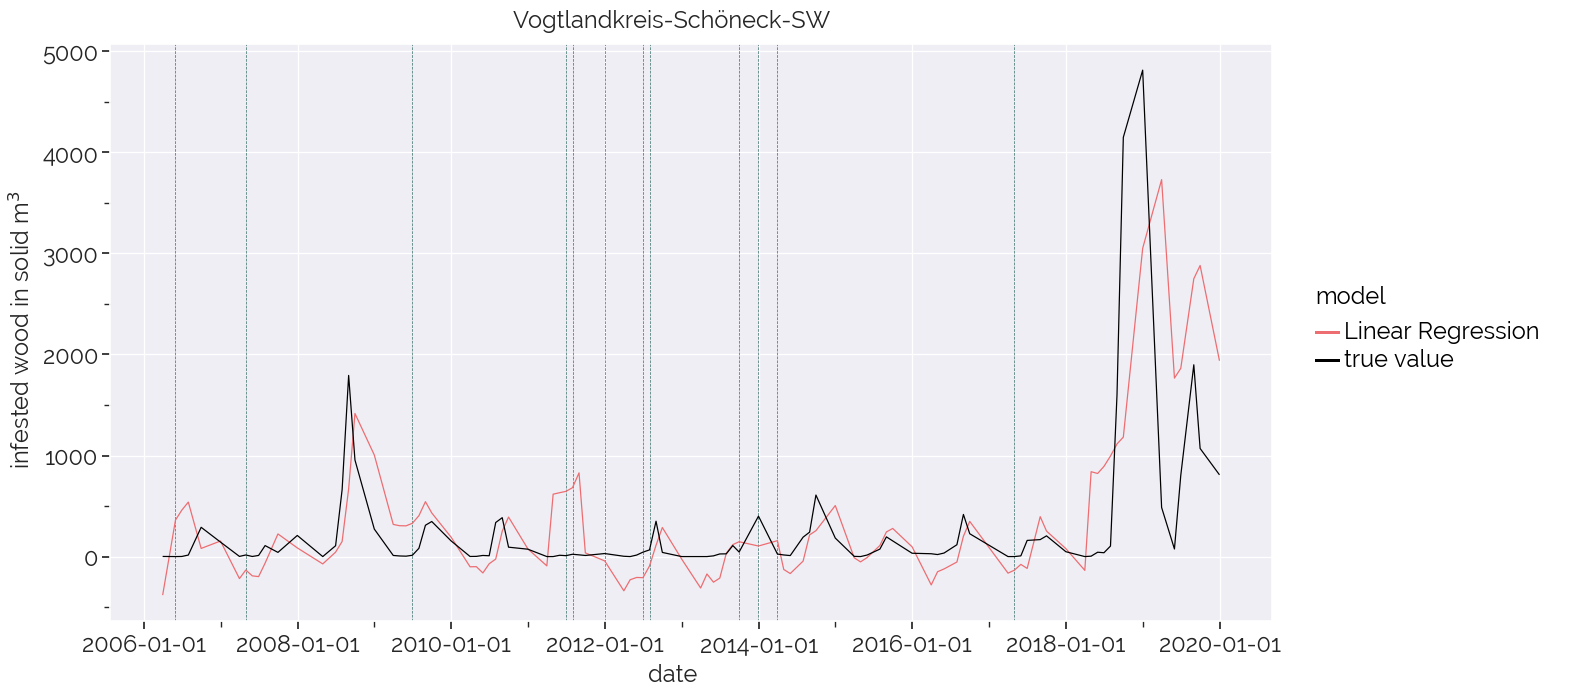

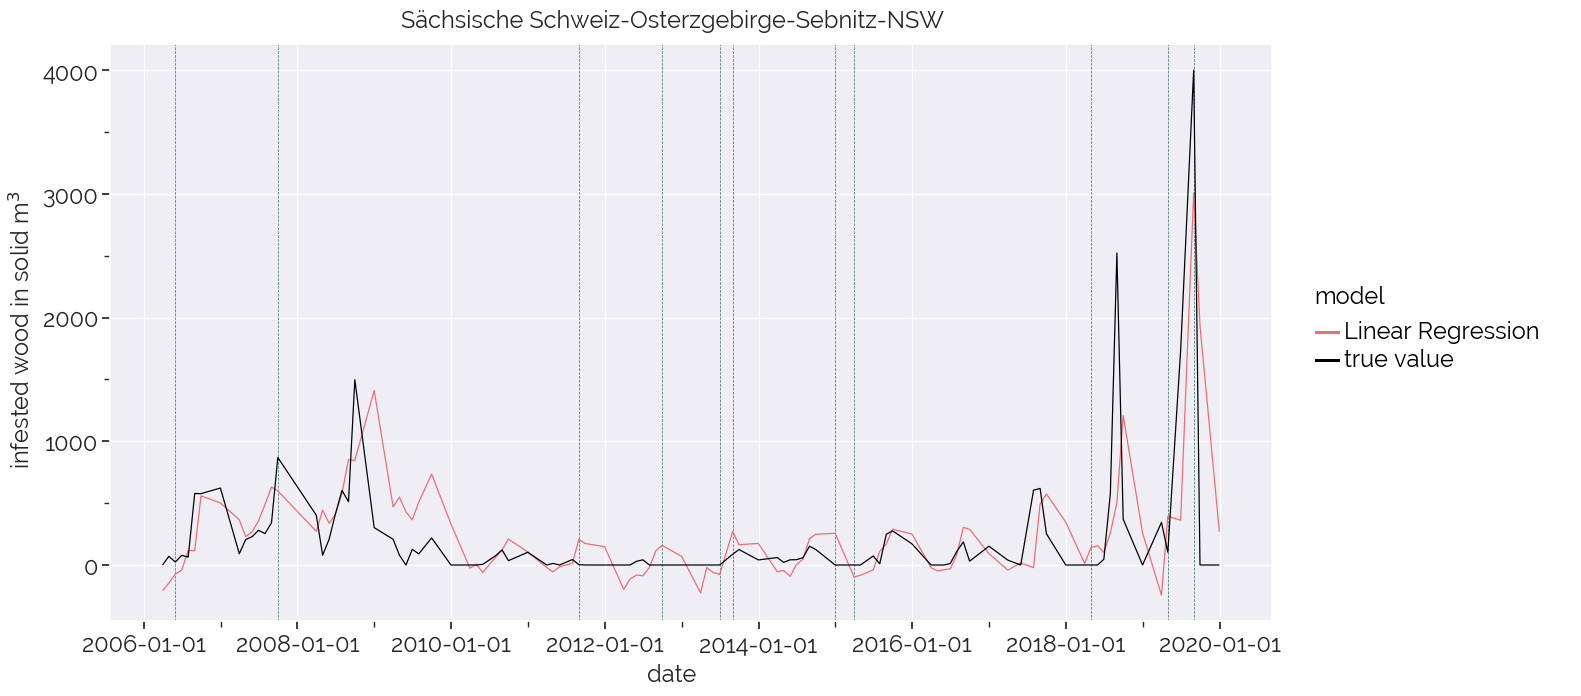

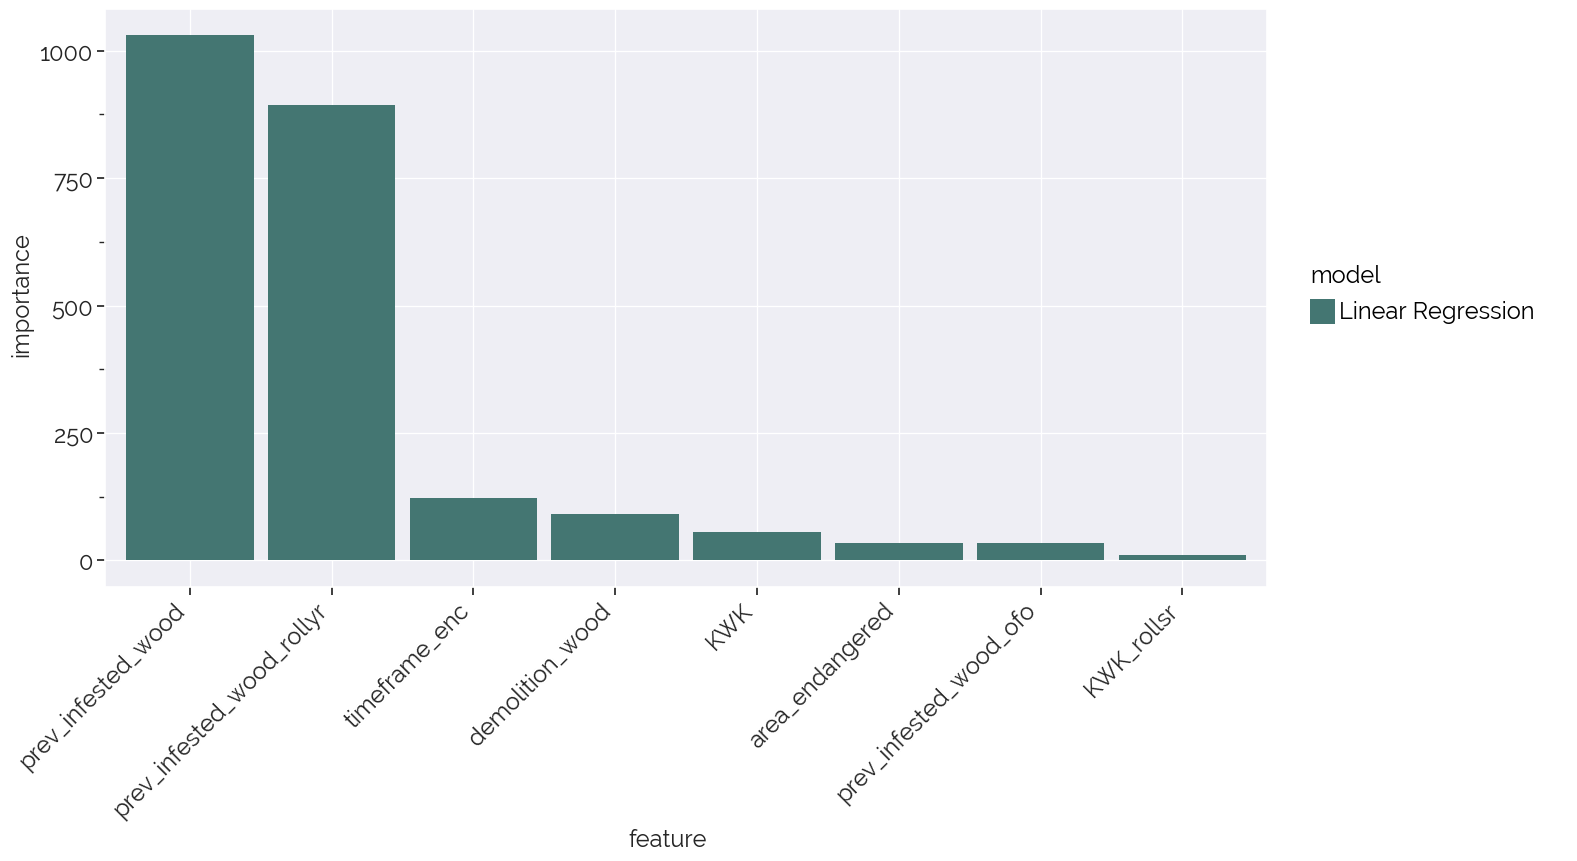

In [22]:
plot_results(base_results_df, base_model, grid_dict,X_train, X_val, 
             y_train, y_val, r'pred_baseline/')

Since the first evaluation plot is mainly used to compare the different regressors and pipelines and we have chosen only a single model as the baseline, it simply serves as a comparison for the training and validation set values in this chapter. The validation set MAE is roughly 290 m$^3$. 

A look at the representative comparison plots for the predicted and actual values reveals, that in many cases even with linear regression a rough estimation for the order of magnitude of the infested wood is possible in a given year. The two main shortcomings of this model seem to be the overly cyclic nature of the predictions, often predicting values even below zero for the first months of a year, as well as the yearly peaks often lying a timeframe behind (and sometimes before) the actual peaks. 

One reason for this phenomenon may be that the model 'corrects' itself after a peak because the amount of previously observed infested wood is a feature in the model and thus used for the next prediction. This is supported by the feature importances plot, because the previous infested wood has the largest associated coefficient. This has serious implications for the deployment of the model, as using the model to make predictions for multiple timeframes in the future (without an actual value in between) would mean the predictions get destablized and the errors quickly go out of hand in a feedback loop. 

The other possible reason for this phenomenon is the nature of the encoded timeframe feature. The feature denotes how much of the yearly infestation is observed **on average** in a given timeframe. In the EDA it was observed that this allocation ratio changed over the years, and that in total as well as in the last few years the infest wood values for September and October-December were uncharacteristically high compared to the earlier years. Since we are using linear regression the model uses these timeframe ratios directly as a coefficient/factor for the prediction, meaning in these earlier years the peaks are likely to get missed. This also explains why the prediction peaks are sometimes registered before the actual values and why sometimes they are on target. In reality both explanations might factor into this phenomenon since both do have likely reasons.

# 4 Model with liberal selection approach & PCA

In this chapter more advanced regression models are trained. It is dubbed 'liberal selection approach' because a large amount of features from the data set will be chosen, even if they were identified as having only minor impact on the target variable. Even though features with a high colinearity are not included, some colinearity likely exists with this approach. To combat this and to improve model training time and efficiency in general, a dimensionality reduction will be performed on the data withing the pipelines. This will be done via Principal Component Analysis (PCA). 

## 4.1 Feature selection

As elaborated, in this 'liberal selection approach' more features than in the baseline model will be chosen. Feature with a correlation approaching +/-1 to included features are not included, as that would not improve model quality even with a PCA. 


In [23]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[[
    # timestamp, id included only to structure results, not used in training
    'timestamp', 'id', 
    'area_endangered', 'timeframe', 
    'centroid_ycoord', 'centroid_xcoord',
    'prev_infested_wood', 'prev_infested_wood_rollyr', 
    'prev_infested_wood_ofo',
    'demolition_wood', 
    'prev_disposed_wood','prev_disposed_wood_rollyr',
    'disposing_rate_demolition', 'disposing_rate_infested_yr',
    'RRK', 'TM0', 'RGK', 'KWK', 'RF0',
    'RRK_rollsr', 'TM0_rollsr', 'RGK_rollsr', 'KWK_rollsr', 'RF0_rollsr',
    'RRK_rollwr', 'TM0_rollwr', 'RGK_rollwr', 'KWK_rollwr', 'RF0_rollwr'
]]

## 4.2 train-val-test split

The exact same split as with the baseline model is chosen to maximize comparibility between models.

In [24]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# make train set according to train_ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=1 - train_ratio 
)

# make validation and test set according to val_ratio and test_ratio
# shuffle already done in first split
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, random_state=0, shuffle=False,
    test_size=test_ratio/(test_ratio + val_ratio) 
)  

# Show the results of the split
print (f'Training set has {X_train.shape[0]} samples.')
print (f'Validation set has {X_val.shape[0]} samples.')
print (f'Testing set has {X_test.shape[0]} samples.')

Training set has 9515 samples.
Validation set has 1189 samples.
Testing set has 1190 samples.


## 4.3 Preparations

The preparation is, again, executet with the functions from chapter 2.1.

In [25]:
# remove id and timestamp and set up results dataframe
lib_results_df = results_setup(X_train, X_val, X_test, y_train, y_val, y_test)

In [26]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   area_endangered             9515 non-null   float64
 1   timeframe_enc               9515 non-null   float64
 2   centroid_ycoord             9515 non-null   float64
 3   centroid_xcoord             9515 non-null   float64
 4   prev_infested_wood          9513 non-null   float64
 5   prev_infested_wood_rollyr   9500 non-null   float64
 6   prev_infested_wood_ofo      9513 non-null   float64
 7   demolition_wood             9511 non-null   float64
 8   prev_disposed_wood          9513 non-null   float64
 9   prev_disposed_wood_rollyr   9500 non-null   float64
 10  disposing_rate_demolition   9511 non-null   float64
 11  disposing_rate_infested_yr  9500 non-null   float64
 12  RRK                         9515 non-null   float64
 13  TM0                         95

## 4.4 Pipeline Setup

The imputer, scaling and one-hot-encoding steps of the pipelines stay the same.

In [28]:
# Creating list for categorical predictors/features 
cat_features = list(X_train.columns[X_train.dtypes==object])
print(f'Categorical features: {cat_features}')

# Creating list for numerical predictors/features
num_features = list(X_train.columns[X_train.dtypes!=object])
print(f'Numerical features: {num_features}')

Categorical features: []
Numerical features: ['area_endangered', 'timeframe_enc', 'centroid_ycoord', 'centroid_xcoord', 'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo', 'demolition_wood', 'prev_disposed_wood', 'prev_disposed_wood_rollyr', 'disposing_rate_demolition', 'disposing_rate_infested_yr', 'RRK', 'TM0', 'RGK', 'KWK', 'RF0', 'RRK_rollsr', 'TM0_rollsr', 'RGK_rollsr', 'KWK_rollsr', 'RF0_rollsr', 'RRK_rollwr', 'TM0_rollwr', 'RGK_rollwr', 'KWK_rollwr', 'RF0_rollwr']


There still are no categorical features among the data.

In [29]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()) # Standardscaler not needed if we use Decision Tree Based Models
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

Now different piplines for the different regressor types are created. The preprocessing pipelines are included as the first step, followed by the PCA and the regression models themselves. The five chosen estimators for regression are XBoost, Random Forest, Gradient Boosting, kNeighbors as well as Support Vector Regression. A list of all pipelines is created according to the specifications of the functions defined in chapter 2.

In [30]:
# Building a full pipeline with our preprocessor, a PCA and a regressor
pipe_xgbr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', XGBRegressor(
        objective='reg:squarederror'
    ))
])

pipe_rfr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', RandomForestRegressor(
        criterion='mae', 
        random_state=0, 
        n_jobs=-1
    ))
])

pipe_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', GradientBoostingRegressor(
        criterion='mae',  
        random_state=0
    ))
])

pipe_knr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', KNeighborsRegressor(
        n_jobs=-1
    ))
])

pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_red', PCA()),
    ('regressor', SVR(
        max_iter=100000
    ))
])

pipelines = [pipe_xgbr, pipe_rfr, pipe_gbr, pipe_knr, pipe_svr]

To fit adequate models a hyperparameter seach is performed. A grid of potential hyperparameter values is constructed.

In [31]:
# defining parameter space for hyperparameter search
search_params_xgbr = [{       
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__learning_rate'    : [0.01, 0.015, 0.02, 0.05, 0.10] ,
    'regressor__max_depth'        : [8, 10, 12, 14, 16],
    'regressor__subsample'        : [0.45, 0.55, 0.65, 0.75],
    'regressor__min_child_weight' : [1, 2, 3, 4],
    'regressor__gamma'            : [0.0, 0.05, 0.1, 0.2 , 0.3],
    'regressor__colsample_bytree' : [0.5, 0,6, 0.7, 1],
    'regressor__colsample_bylevel': [0.75, 1],
    'regressor__colsample_bynode' : [0.75, 1],
    'regressor__n_estimators'     : [75, 100, 125, 175],
}]

search_params_rfr = [{    
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__max_depth'        : [10, 12, 15, 17, 20],
    'regressor__min_samples_split': [2, 5, 8],
    'regressor__max_features'     : ['log2', 'sqrt', None],
    'regressor__bootstrap'        : [True, False],
    'regressor__min_samples_leaf' : [2, 3, 4, 5, 6],
    'regressor__n_estimators'     : range(75,200,25),
}]
 
search_params_gbr = [{ 
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__learning_rate'    : [0.05, 0.1, 0.15, 0.2, 0.25],
    'regressor__min_samples_split': np.linspace(0.01, 0.15, 8),
    'regressor__min_samples_leaf' : np.linspace(0.01, 0.15, 8),
    'regressor__max_depth'        : [5, 10, 15, 20, 25],
    'regressor__max_features'     : ['log2','sqrt', None],
    'regressor__subsample'        : [0.8, 0.9, 1.0, 1.1, 1.2],
    'regressor__n_estimators'     : range(125,326,50),    
}]

search_params_knr = [{
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__metric'           : ['manhattan', 'euclidean', 'minkowski'],
    'regressor__n_neighbors'      : range(3, 81, 1),
    'regressor__weights'          : ['uniform', 'distance'],   
}]

search_params_svr = [{ 
    'dim_red__n_components'       : range(5, 16, 2),
    'regressor__kernel'           : ['rbf', 'sigmoid', 'poly', 'linear'],
    'regressor__degree'           : [2, 3],
    'regressor__gamma'            : np.linspace(0.0001, 10, 25),
    'regressor__C'                : np.linspace(0.1, 100, 25),
}]


Finally, we combine the pipelines and hyperparametergrids in sklearn.model_selection.RandomizedSearchCV objects. We use a randomized, cross-validated search as can search a more elaborate grid as a full grid search in the same time while yielding roghly equivalent results. As discussed, the MAE will be used as the evaluation metric for scoring the models. Different numbers of parameter setting n_iter are used, depending on the size of the hyperparameter grid as well as the individual regressor training time. A list of all pipelines and the grid_dict dictionary are created as specified in the functions of chapter 2. 

In [32]:
scoring = 'neg_mean_absolute_error'
cv = 3
n_jobs=-1
verbose=1
random_state=0

# specify search hyperparameters
rs_xgbr = RandomizedSearchCV(pipe_xgbr, 
                             param_distributions=search_params_xgbr, 
                             cv=cv, 
                             scoring=scoring, 
                             verbose=verbose, 
                             n_jobs=n_jobs, 
                             random_state=random_state, 
                             n_iter=4000) 

rs_rfr = RandomizedSearchCV(pipe_rfr, 
                            param_distributions=search_params_rfr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=40)

rs_gbr = RandomizedSearchCV(pipe_gbr, 
                            param_distributions=search_params_gbr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=12)

rs_knr = RandomizedSearchCV(pipe_knr, 
                            param_distributions=search_params_knr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=200)

rs_svr = RandomizedSearchCV(pipe_svr, 
                            param_distributions=search_params_svr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=200)

grids = [rs_xgbr, rs_rfr, rs_gbr, rs_knr, rs_svr]

# Dictionary of pipelines and regressor types for ease of reference
grid_dict = {0: 'XGBoost', 1: 'Random Forest', 
             2: 'Gradient Boosted Trees', 3: 'KNeighbors', 
             4: 'Support Vector Regression'}

## 4.5 Model Training

Since the data, pipelines and hyperparameter grids are prepared, the model training for the liberal selectiona approach can begin. First, compare the untuned models cross-validation scores for the training set.

In [33]:
crossvalscores(pipelines, X_train, y_train)

Cross validation scores for XGBRegressor(objective='reg:squarederror'):
-------------------------
MAE: 242.82
RMSE: 1793.93
Explained Variance: 0.42


Cross validation scores for RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=0):
-------------------------
MAE: 253.31
RMSE: 2025.13
Explained Variance: 0.26


Cross validation scores for GradientBoostingRegressor(criterion='mae', random_state=0):
-------------------------
MAE: 241.03
RMSE: 2164.06
Explained Variance: 0.16


Cross validation scores for KNeighborsRegressor(n_jobs=-1):
-------------------------
MAE: 209.46
RMSE: 1686.29
Explained Variance: 0.49


Cross validation scores for SVR(max_iter=100000):
-------------------------
MAE: 257.87
RMSE: 2370.29
Explained Variance: 0.00




Here, the untuned kNeighbors regression has the edge regarding all evaluation metrics. However these values only serve as another kind of baseline and don't really have much meaning, as the real model training has yet to be performed.

In [34]:
best_models_lib = randomsearchcv(grids, grid_dict, X_train, y_train, X_val, y_val)

Performing model optimizations...

Estimator: XGBoost
Fitting 3 folds for each of 4000 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

Best params: {'regressor__subsample': 0.75, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 16, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0.0, 'regressor__colsample_bytree': 1, 'regressor__colsample_bynode': 1, 'regressor__colsample_bylevel': 0.75, 'dim_red__n_components': 15}
Best training MAE: 201.32
Validation set MAE for best params: 188.68

Estimator: Random Forest
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 43.1min finished


Best params: {'regressor__n_estimators': 150, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 3, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 10, 'regressor__bootstrap': False, 'dim_red__n_components': 7}
Best training MAE: 208.42
Validation set MAE for best params: 196.35

Estimator: Gradient Boosted Trees
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 31.9min finished


Best params: {'regressor__subsample': 1.0, 'regressor__n_estimators': 275, 'regressor__min_samples_split': 0.03, 'regressor__min_samples_leaf': 0.03, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 20, 'regressor__learning_rate': 0.2, 'dim_red__n_components': 11}
Best training MAE: 223.04
Validation set MAE for best params: 235.02

Estimator: KNeighbors
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.8s finished


Best params: {'regressor__weights': 'distance', 'regressor__n_neighbors': 10, 'regressor__metric': 'manhattan', 'dim_red__n_components': 15}
Best training MAE: 216.04
Validation set MAE for best params: 203.74

Estimator: Support Vector Regression
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.9min finished


Best params: {'regressor__kernel': 'linear', 'regressor__gamma': 3.3334, 'regressor__degree': 2, 'regressor__C': 33.400000000000006, 'dim_red__n_components': 15}
Best training MAE: 215.24
Validation set MAE for best params: 220.00


Summary of validation set errors
XGBoost:
-------------------------
MAE: 188.68
RMSE: 1486.65
Explained Variance: 0.47



Summary of validation set errors
Random Forest:
-------------------------
MAE: 196.35
RMSE: 1407.00
Explained Variance: 0.52



Summary of validation set errors
Gradient Boosted Trees:
-------------------------
MAE: 235.02
RMSE: 1806.34
Explained Variance: 0.21



Summary of validation set errors
KNeighbors:
-------------------------
MAE: 203.74
RMSE: 1377.59
Explained Variance: 0.54



Summary of validation set errors
Support Vector Regression:
-------------------------
MAE: 220.00
RMSE: 1619.29
Explained Variance: 0.37


Regressor with best validation set MAE: XGBoost


## 4.6 Model Evaluation

Before we evaluate the models, let's get a complete picture of the results by using the plot_results function.

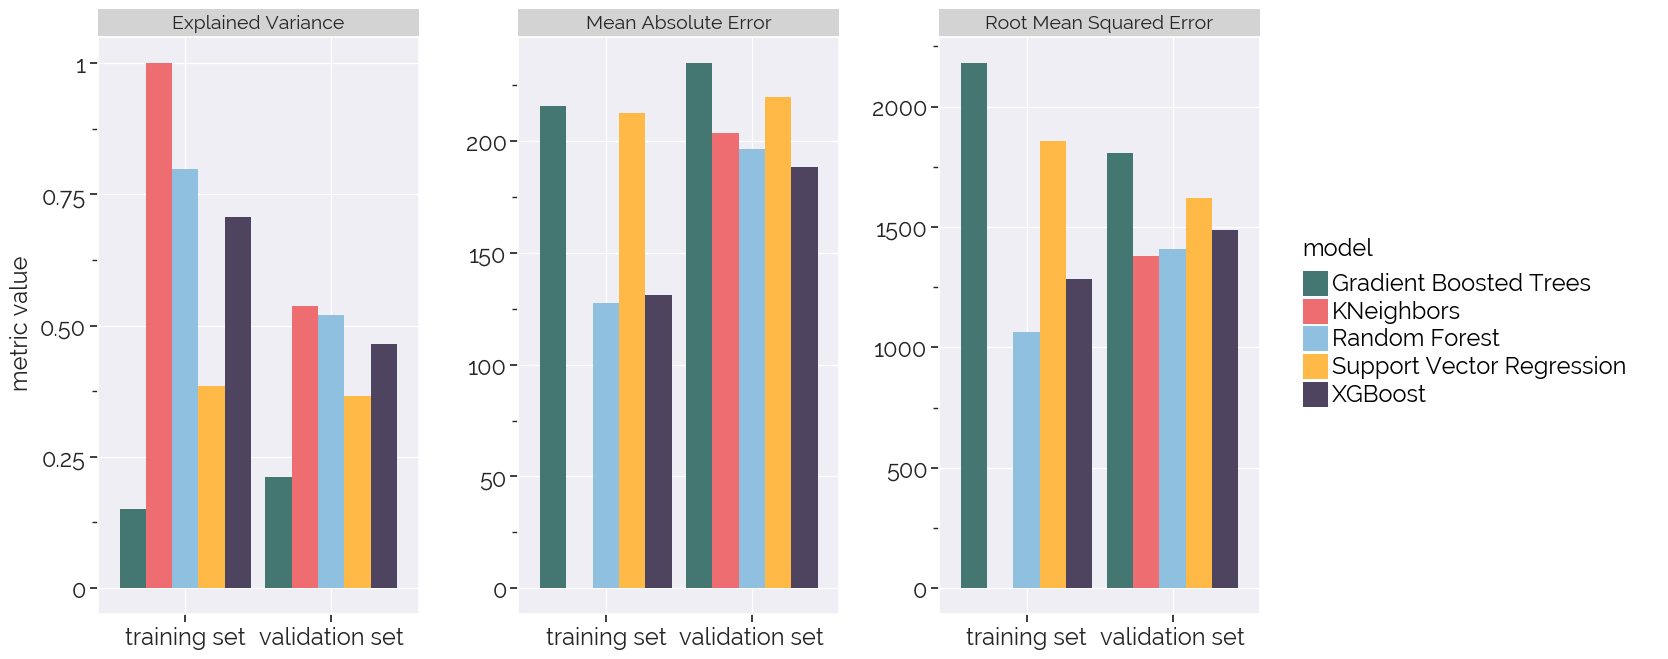

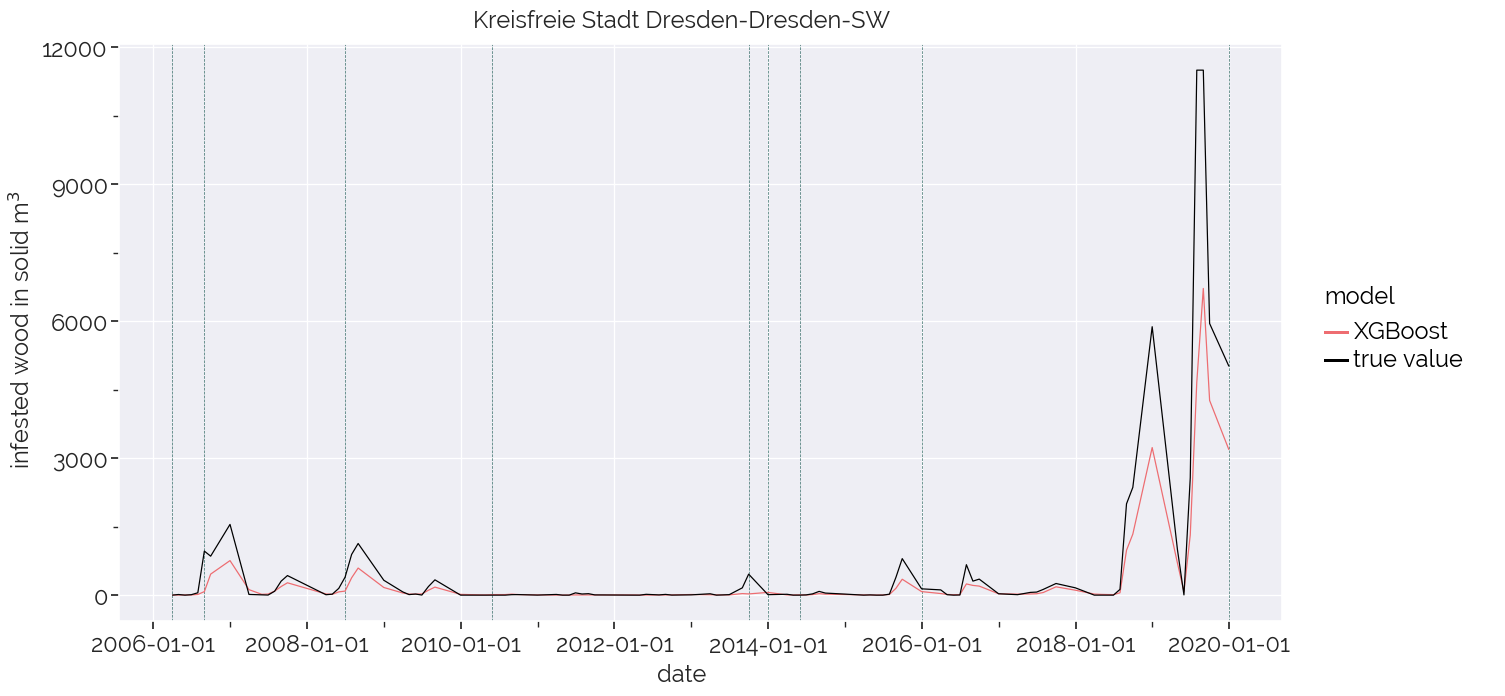

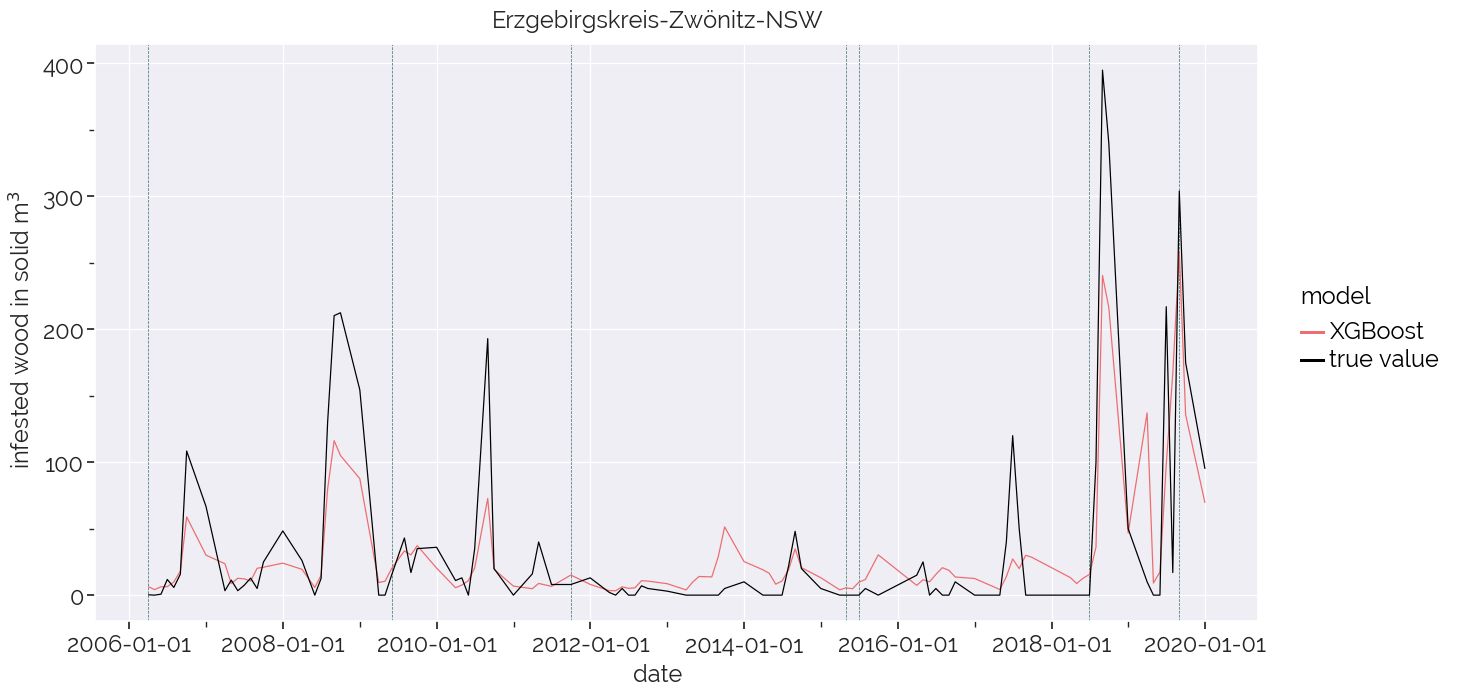

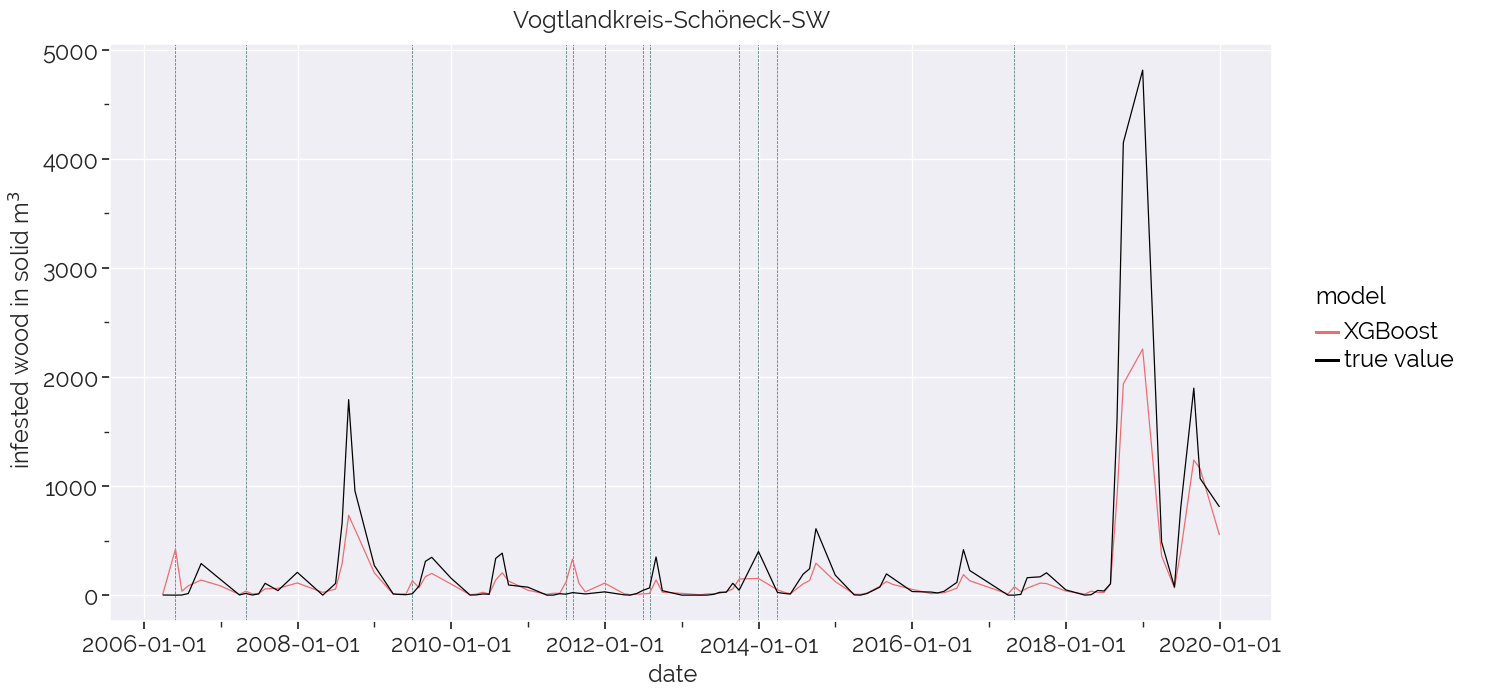

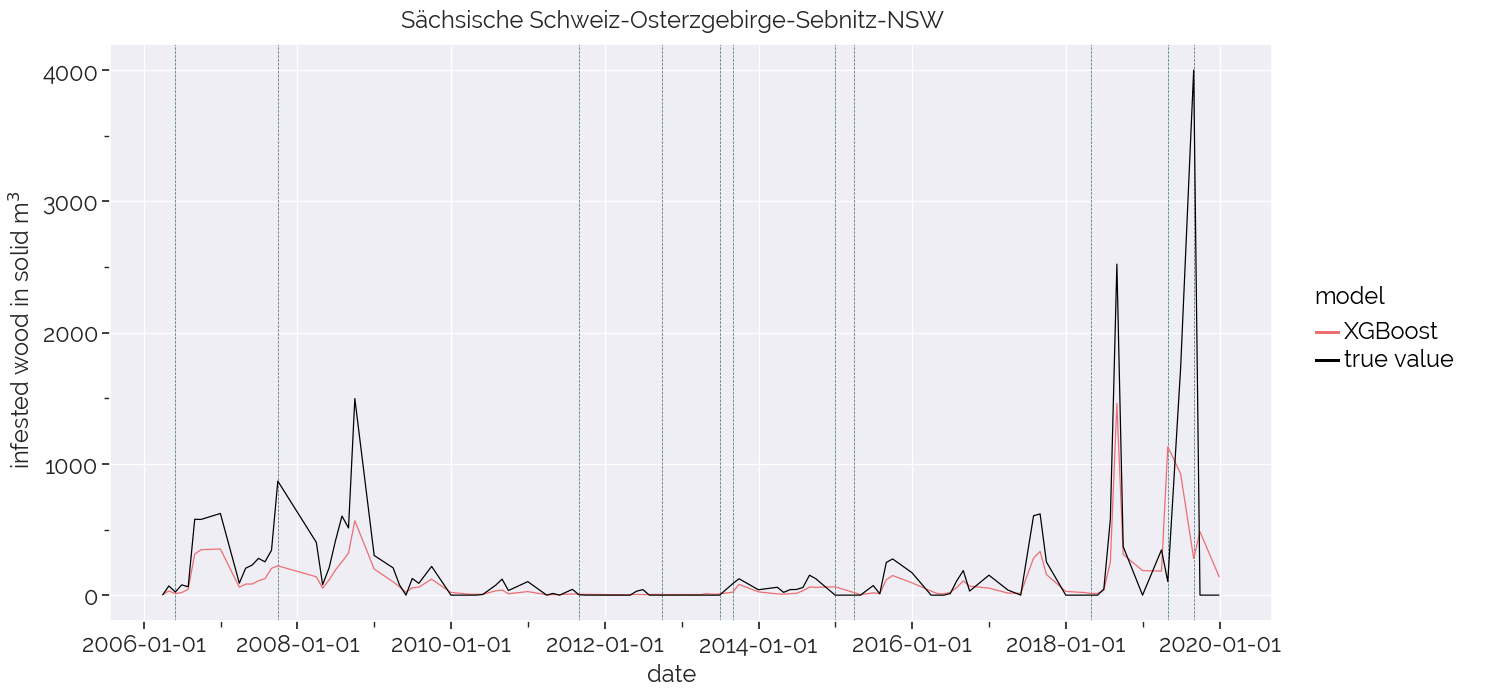

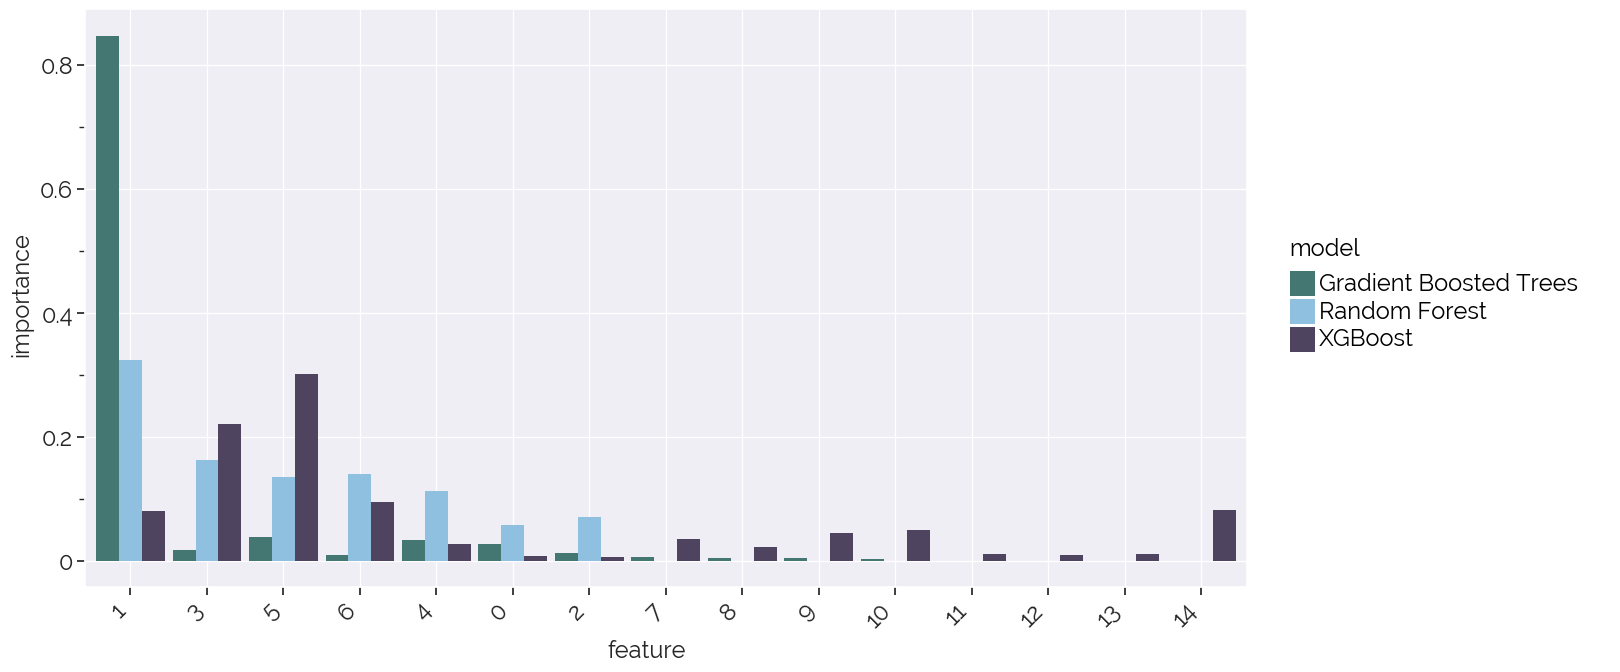

In [47]:
plot_results(lib_results_df, best_models_lib, grid_dict, X_train, X_val, 
             y_train, y_val, r'pred_liberal/')

All models were able to improve upon the baseline models validation set MAE with varying success, which was the main goal in fitting these models. However while optimizing for this metric, the secondary evaluation metrics, specifically root mean square error (RMSE) and explained variance, saw no or only slight improvements for the validation set. 

The best performing model type for this approach was undeniably the XGBoost regressor, followed by Random Forest. An honorable mention goes out to k-Neighbors regression for having the best secondary evaluation metrics. However, the k-Neighbors model seems to be heavily overfitted. Its training set performance is perfect, since the model was trained on the whole (training) data set that it is predicting, while the 'weights' hyperparameter was set to 'distance'. This makes it a textbook case of overfitting, since the weighting for each point in the training set will be essentially 1.

The XGBoost predictions also show qualitative improvements upon the linear regression baseline, as now the seasonality does not cause the values to drop below zero regularly. Furthermore, the correct timeframes for yearly peaks are hit more reliably, which might be a result of regression trees being able to better deal with the problems outlined during the baseline model analysis or a byproduct of the PCA transforming and diffusing multiple features.

Feature importance analysis indicates that some of the reduced features are only sparsely used by the XGBoost model. This was the case even though the number of reduced features itself was a hyperparameter during model tuning. Still, some of them might not be contribute much to the overall model performance. Gradient Boosting demonstrates an even greater dependance on only a few select features while only for the Random Forest an lower number of reduced features was actually chosen as a hyperparameter. Maybe some of the reduced features could be dropped before fitting the model without jeopardizing model accuracy. Alternatively, the number of reduced features could be adjusted manually. Otherwise, the approach of a PCA combined with liberal feature selection is simply not the optimal strategy for getting the most suitable model.

# 5 Model with frugal selection approach

A last set of models is fitted in this chapter, which is dubbed 'frugal selection approach', as the features are selected with the philosophy of choosing a minimal amount features with the highest significance. This contrasts the approach from the previous chapter, which was to achieve maximum model performance by including any relevant feature possible. For this reason, a PCA or other form of dimensionality reduction will not be applied in this current chapter. 

Over the course of this project, many more models, data transformations and combinations of features were tested as part of the iterative nature of the data science life cycle. Only these three approaches (baseline model, multiple sets of models with a liberal selection of features and multiple sets of models with a frugal selection of features) were kept in the final version of this notebook, as the other procedures did not yield better results while cluttering up the notebook and taking up computational resources. 

## 5.1 Feature selection

The frugally selected features are defined in the following code. The temperature and precipitation were chosen as the climate parameters on the behest of *Sachsenforst*, as they can be directly measured and are more intuitive in comparison than for example the climatic water balance. This would make the data maintenance much easier if this minimal approach yields the desired results. 

In [48]:
# pre-filter for features and train test split to prevent data leakage
y = data['infested_wood']
X = data[[
    # timestamp, id included only to structure results, not used in training
    'timestamp', 'id', 
    'area_endangered', 'timeframe',
    'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo',
    'RRK', 'TM0',
    'demolition_wood', 
    'RRK_rollsr'

]]

## 5.2 train-val-test split

The exact same split as with the previous set of models is chosen to maximize comparibility between approaches.

In [49]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# make train set according to train_ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=1 - train_ratio 
)

# make validation and test set according to val_ratio and test_ratio
# shuffle already done in first split
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, random_state=0, shuffle=False,
    test_size=test_ratio/(test_ratio + val_ratio) 
)  

# Show the results of the split
print (f'Training set has {X_train.shape[0]} samples.')
print (f'Validation set has {X_val.shape[0]} samples.')
print (f'Testing set has {X_test.shape[0]} samples.')

Training set has 9515 samples.
Validation set has 1189 samples.
Testing set has 1190 samples.


## 5.3 Preparations

The preparation is, again, executet with the functions from chapter 2.1.

In [50]:
# remove id and timestamp and set up results dataframe
fru_results_df = results_setup(X_train, X_val, X_test, y_train, y_val, y_test)

In [51]:
# use function to encode the months in timeframe column
X_train, X_val, X_test = month_num_encoder(X_train, y_train, X_val, X_test)

In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9515 entries, 3409 to 3092
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   area_endangered            9515 non-null   float64
 1   timeframe_enc              9515 non-null   float64
 2   prev_infested_wood         9513 non-null   float64
 3   prev_infested_wood_rollyr  9500 non-null   float64
 4   prev_infested_wood_ofo     9513 non-null   float64
 5   RRK                        9515 non-null   float64
 6   TM0                        9515 non-null   float64
 7   demolition_wood            9511 non-null   float64
 8   RRK_rollsr                 9502 non-null   float64
dtypes: float64(9)
memory usage: 743.4 KB


## 5.4 Pipeline Setup

The imputer, scaling and one-hot-encoding steps of the pipelines stay the same.

In [53]:
# Creating list for categorical predictors/features 
cat_features = list(X_train.columns[X_train.dtypes==object])
print(f'Categorical features: {cat_features}')

# Creating list for numerical predictors/features
num_features = list(X_train.columns[X_train.dtypes!=object])
print(f'Numerical features: {num_features}')

Categorical features: []
Numerical features: ['area_endangered', 'timeframe_enc', 'prev_infested_wood', 'prev_infested_wood_rollyr', 'prev_infested_wood_ofo', 'RRK', 'TM0', 'demolition_wood', 'RRK_rollsr']


In [54]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()) 
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

Now different piplines for the different regressor types are created. The preprocessing pipelines are included as the first step, followed by the regressors themselves. The five chosen estimators for regression are the same as with the liberal selection approach. A list of all pipelines is created according to the specifications of the functions defined in chapter 2.

In [55]:
# Building a full pipeline with our preprocessor and a Regressor
pipe_xgbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror'
    ))
])

pipe_rfr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        criterion='mae', 
        random_state=0, 
        n_jobs=-1
    ))
])

pipe_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        criterion='mae',  
        random_state=0
    ))
])

pipe_knr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(
        n_jobs=-1
    ))
])

pipe_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(
        max_iter=100000
    ))
])

pipelines = [pipe_xgbr, pipe_rfr, pipe_gbr, pipe_knr, pipe_svr]

To fit adequate models a hyperparameter seach is performed. A grid of potential hyperparameter values is constructed.

In [56]:
# defining parameter space for hyperparameter search
search_params_xgbr = [{                 
    'regressor__learning_rate'    : [0.01, 0.015, 0.02, 0.05, 0.10] ,
    'regressor__max_depth'        : [8, 10, 12, 14, 16],
    'regressor__subsample'        : [0.45, 0.55, 0.65, 0.75],
    'regressor__min_child_weight' : [1, 2, 3, 4],
    'regressor__gamma'            : [0.0, 0.05, 0.1, 0.2 , 0.3],
    'regressor__colsample_bytree' : [0.5, 0,6, 0.7, 1],
    'regressor__colsample_bylevel': [0.75, 1],
    'regressor__colsample_bynode' : [0.75, 1],
    'regressor__n_estimators'     : [75, 100, 125, 175],
}]

search_params_rfr = [{    
    'regressor__max_depth'         : [10, 12, 15, 17, 20],
    'regressor__min_samples_split' : [2, 5, 8],
    'regressor__max_features'      : ['log2', 'sqrt', None],
    'regressor__bootstrap'         : [True, False],
    'regressor__min_samples_leaf'  : [2, 3, 4, 5, 6],
    'regressor__n_estimators'      : range(75,200,25),
}]
 
search_params_gbr = [{ 
    'regressor__learning_rate'     : [0.05, 0.1, 0.15, 0.2, 0.25],
    'regressor__min_samples_split' : np.linspace(0.01, 0.15, 8),
    'regressor__min_samples_leaf'  : np.linspace(0.01, 0.15, 8),
    'regressor__max_depth'         : [5, 10, 15, 20, 25],
    'regressor__max_features'      : ['log2','sqrt', None],
    'regressor__subsample'         : [0.8, 0.9, 1.0, 1.1, 1.2],
    'regressor__n_estimators'      : range(125,326,50),    
}]

search_params_knr = [{
    'regressor__metric'            : ['manhattan', 'euclidean', 'minkowski'],
    'regressor__n_neighbors'       : range(5, 81, 1),
    'regressor__weights'           : ['uniform', 'distance'],   
}]

search_params_svr = [{ 
    'regressor__kernel'            : ['rbf', 'sigmoid', 'poly', 'linear'],
    'regressor__degree'            : [2, 3],
    'regressor__gamma'             : np.linspace(0.0001, 10, 25),
    'regressor__C'                 : np.linspace(0.1, 100, 25),
}]


The sklearn.model_selection.RandomizedSearchCV objects are constructed in the same way as in the previous chapter, again to maximize comparability.

In [57]:
scoring = 'neg_mean_absolute_error'
cv = 3
n_jobs=-1
verbose=1
random_state=0

# specify search hyperparameters
rs_xgbr = RandomizedSearchCV(pipe_xgbr, 
                             param_distributions=search_params_xgbr, 
                             cv=cv, 
                             scoring=scoring, 
                             verbose=verbose, 
                             n_jobs=n_jobs, 
                             random_state=random_state, 
                             n_iter=4000) 

rs_rfr = RandomizedSearchCV(pipe_rfr, 
                            param_distributions=search_params_rfr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=40)

rs_gbr = RandomizedSearchCV(pipe_gbr, 
                            param_distributions=search_params_gbr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=12)

rs_knr = RandomizedSearchCV(pipe_knr, 
                            param_distributions=search_params_knr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=200)

rs_svr = RandomizedSearchCV(pipe_svr, 
                            param_distributions=search_params_svr, 
                            cv=cv, 
                            scoring=scoring, 
                            verbose=verbose, 
                            n_jobs=n_jobs, 
                            random_state=random_state, 
                            n_iter=200)

grids = [rs_xgbr, rs_rfr, rs_gbr, rs_knr, rs_svr]

# Dictionary of pipelines and regressor types for ease of reference
grid_dict = {0: 'XGBoost', 1: 'Random Forest', 
             2: 'Gradient Boosted Trees', 3: 'KNeighbors', 
             4: 'Support Vector Regression'}

## 5.5 Model Training

In [58]:
crossvalscores(pipelines, X_train, y_train)

Cross validation scores for XGBRegressor(objective='reg:squarederror'):
-------------------------
MAE: 222.96
RMSE: 1822.98
Explained Variance: 0.40


Cross validation scores for RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=0):
-------------------------
MAE: 211.16
RMSE: 1692.05
Explained Variance: 0.49


Cross validation scores for GradientBoostingRegressor(criterion='mae', random_state=0):
-------------------------
MAE: 197.49
RMSE: 1740.96
Explained Variance: 0.46


Cross validation scores for KNeighborsRegressor(n_jobs=-1):
-------------------------
MAE: 219.32
RMSE: 1758.93
Explained Variance: 0.44


Cross validation scores for SVR(max_iter=100000):
-------------------------
MAE: 256.58
RMSE: 2368.55
Explained Variance: 0.00




In [59]:
best_models_fru = randomsearchcv(grids, grid_dict, 
                                 X_train, y_train, X_val, y_val)

Performing model optimizations...

Estimator: XGBoost
Fitting 3 folds for each of 4000 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

Best params: {'regressor__subsample': 0.45, 'regressor__n_estimators': 100, 'regressor__min_child_weight': 1, 'regressor__max_depth': 16, 'regressor__learning_rate': 0.02, 'regressor__gamma': 0.05, 'regressor__colsample_bytree': 1, 'regressor__colsample_bynode': 0.75, 'regressor__colsample_bylevel': 0.75}
Best training MAE: 185.14
Validation set MAE for best params: 176.03

Estimator: Random Forest
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 15.9min finished


Best params: {'regressor__n_estimators': 75, 'regressor__min_samples_split': 8, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'log2', 'regressor__max_depth': 10, 'regressor__bootstrap': False}
Best training MAE: 180.85
Validation set MAE for best params: 165.58

Estimator: Gradient Boosted Trees
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  5.8min finished


Best params: {'regressor__subsample': 1.0, 'regressor__n_estimators': 275, 'regressor__min_samples_split': 0.12999999999999998, 'regressor__min_samples_leaf': 0.03, 'regressor__max_features': 'log2', 'regressor__max_depth': 25, 'regressor__learning_rate': 0.1}
Best training MAE: 219.03
Validation set MAE for best params: 233.70

Estimator: KNeighbors
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   34.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best params: {'regressor__weights': 'distance', 'regressor__n_neighbors': 15, 'regressor__metric': 'manhattan'}
Best training MAE: 196.65
Validation set MAE for best params: 178.87

Estimator: Support Vector Regression
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.5min finished


Best params: {'regressor__kernel': 'linear', 'regressor__gamma': 6.2500374999999995, 'regressor__degree': 3, 'regressor__C': 29.237500000000004}
Best training MAE: 190.29
Validation set MAE for best params: 195.21


Summary of validation set errors
XGBoost:
-------------------------
MAE: 176.03
RMSE: 1328.25
Explained Variance: 0.57



Summary of validation set errors
Random Forest:
-------------------------
MAE: 165.58
RMSE: 1257.94
Explained Variance: 0.62



Summary of validation set errors
Gradient Boosted Trees:
-------------------------
MAE: 233.70
RMSE: 1818.02
Explained Variance: 0.20



Summary of validation set errors
KNeighbors:
-------------------------
MAE: 178.87
RMSE: 1327.90
Explained Variance: 0.57



Summary of validation set errors
Support Vector Regression:
-------------------------
MAE: 195.21
RMSE: 1420.21
Explained Variance: 0.51


Regressor with best validation set MAE: Random Forest


## 5.6 Model Evaluation

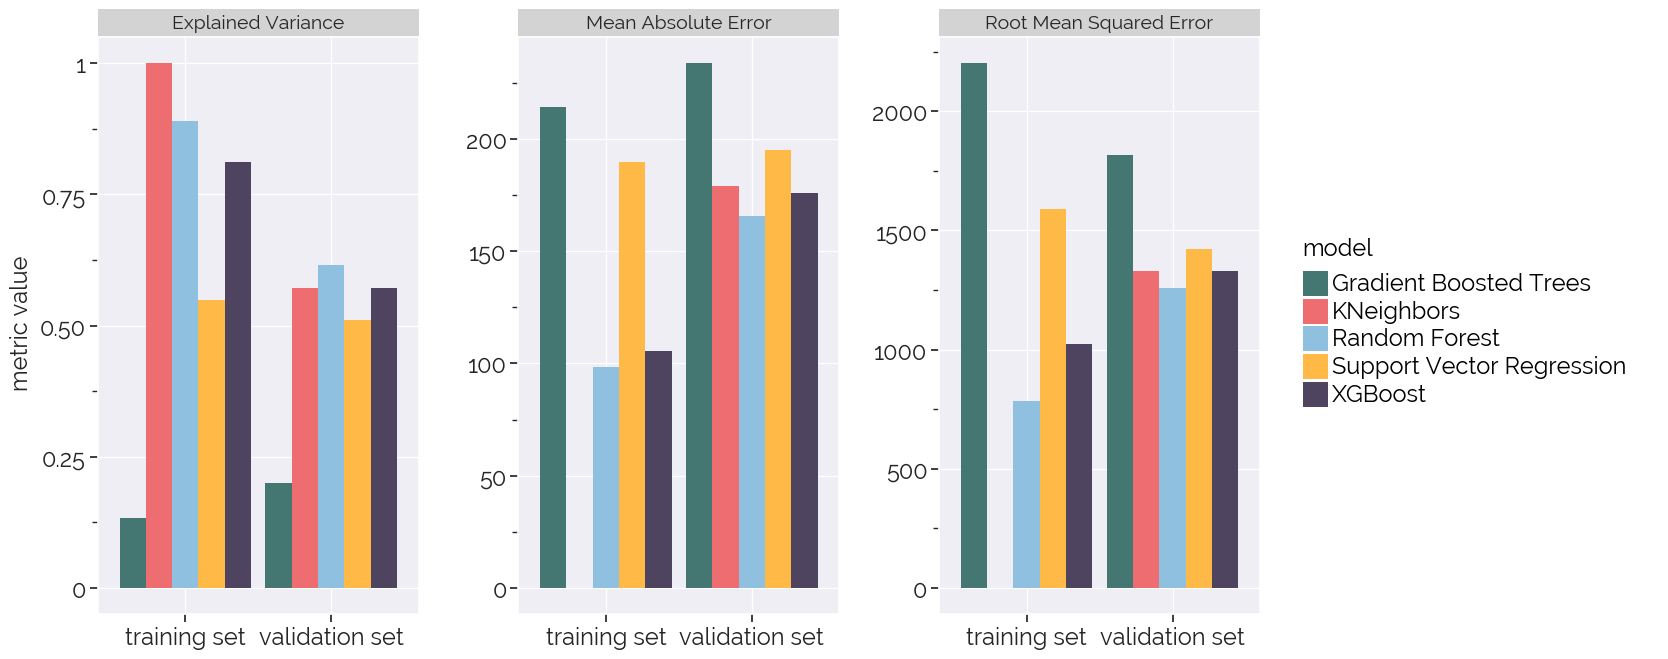

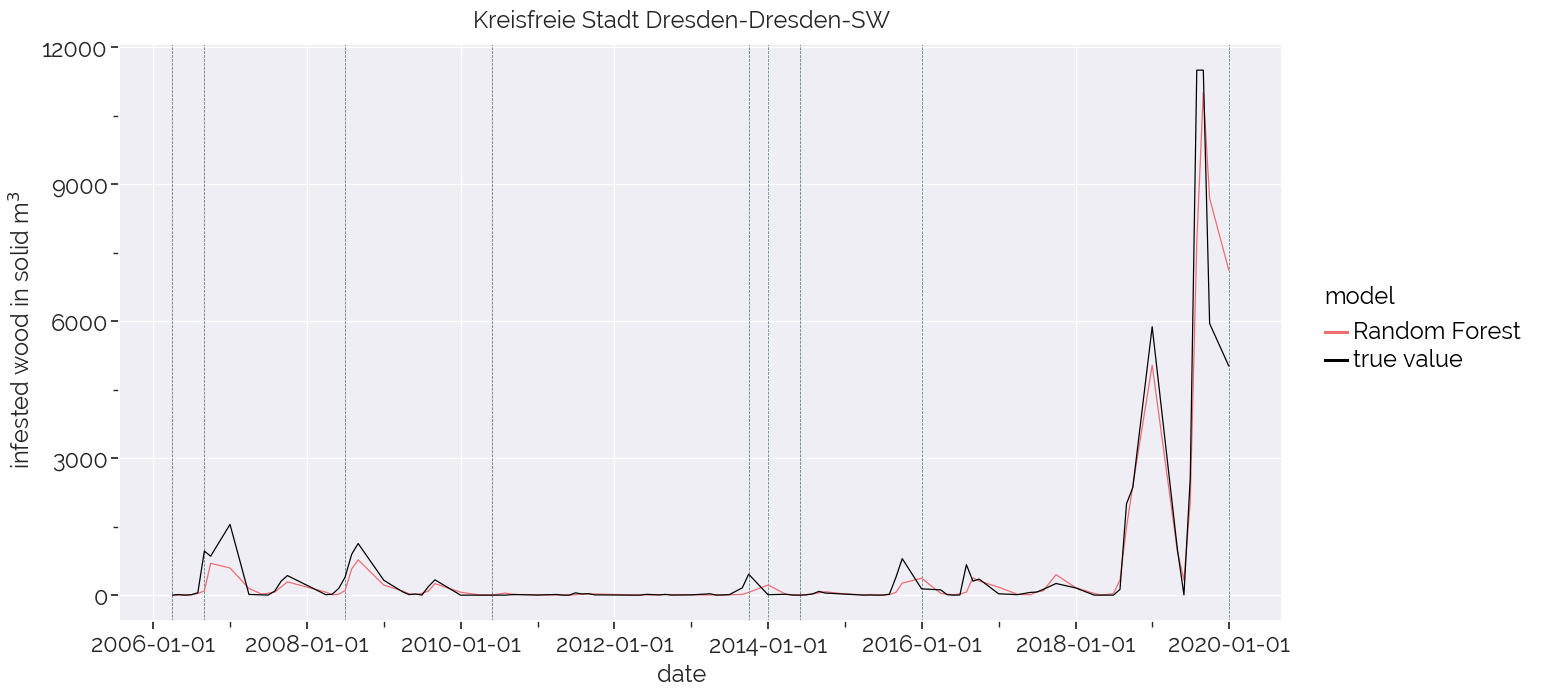

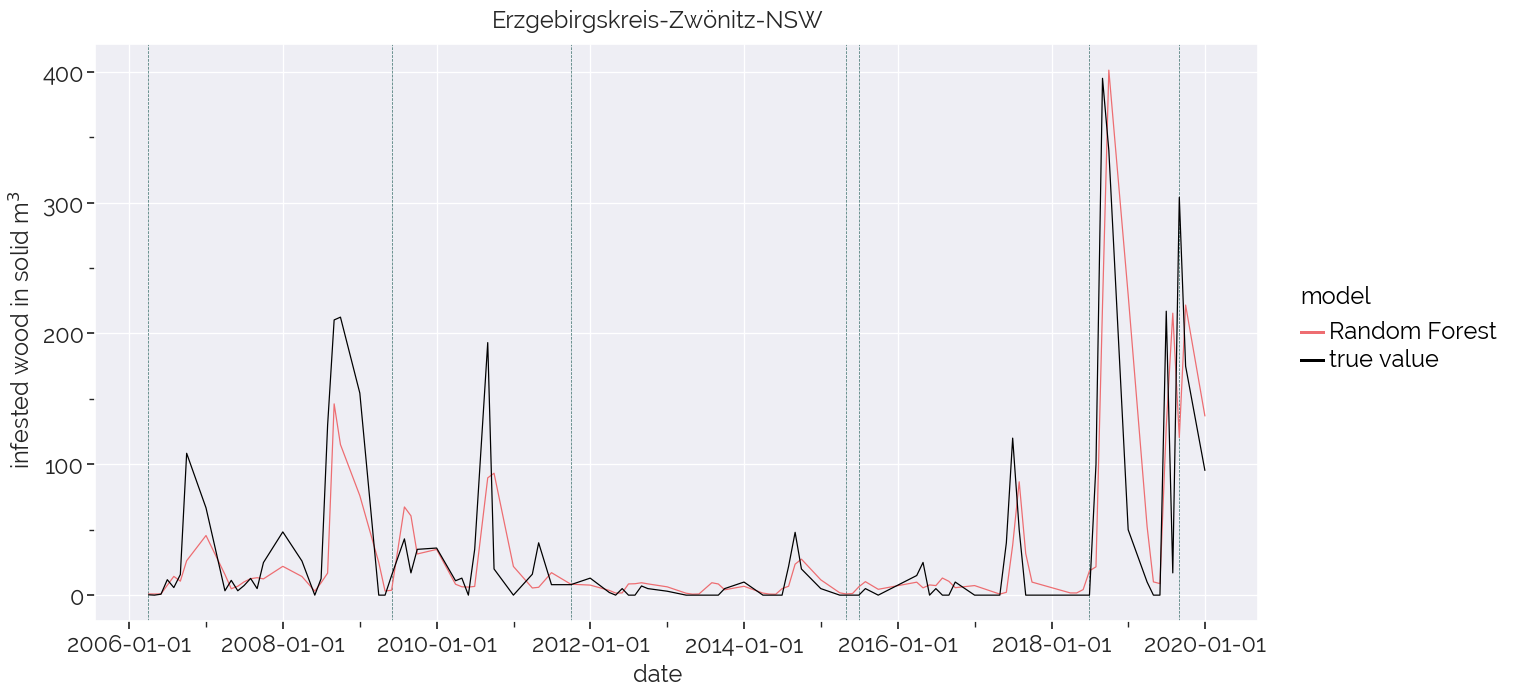

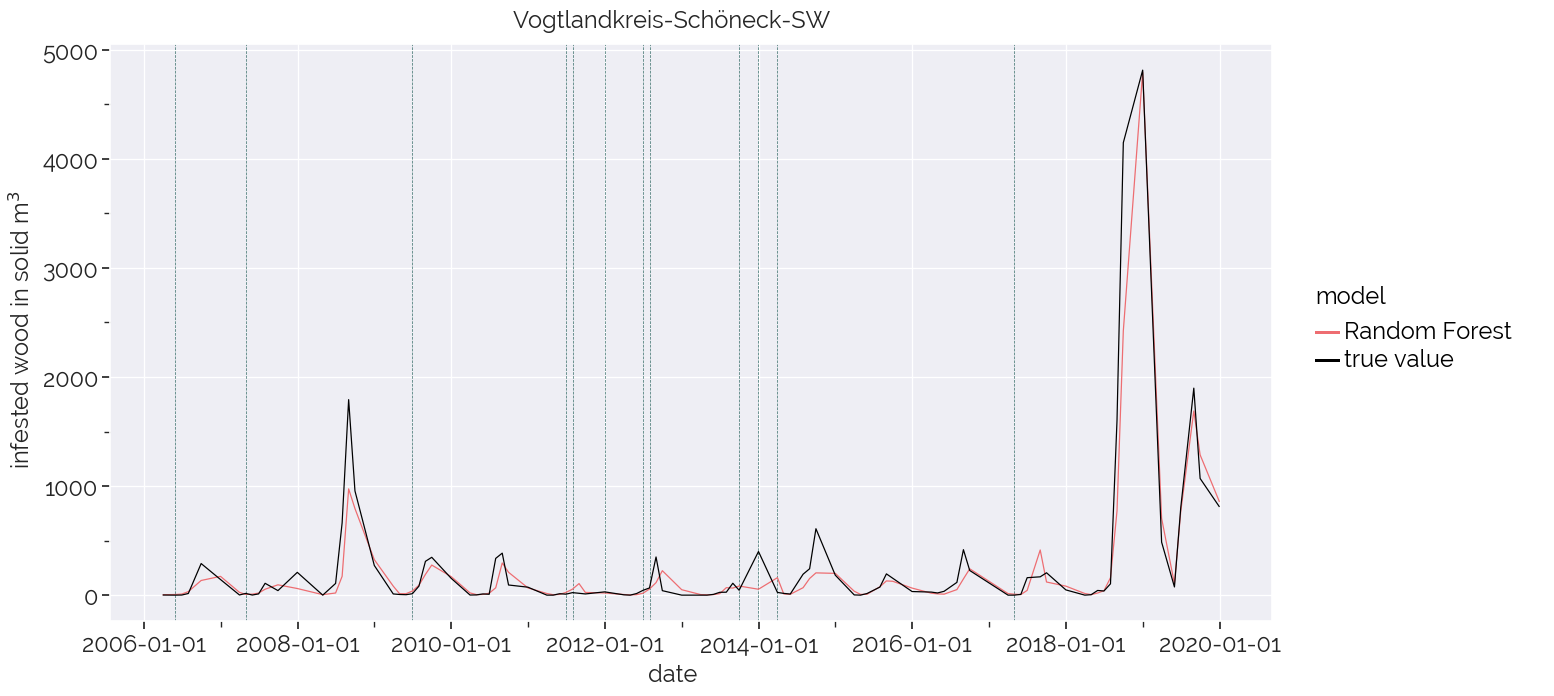

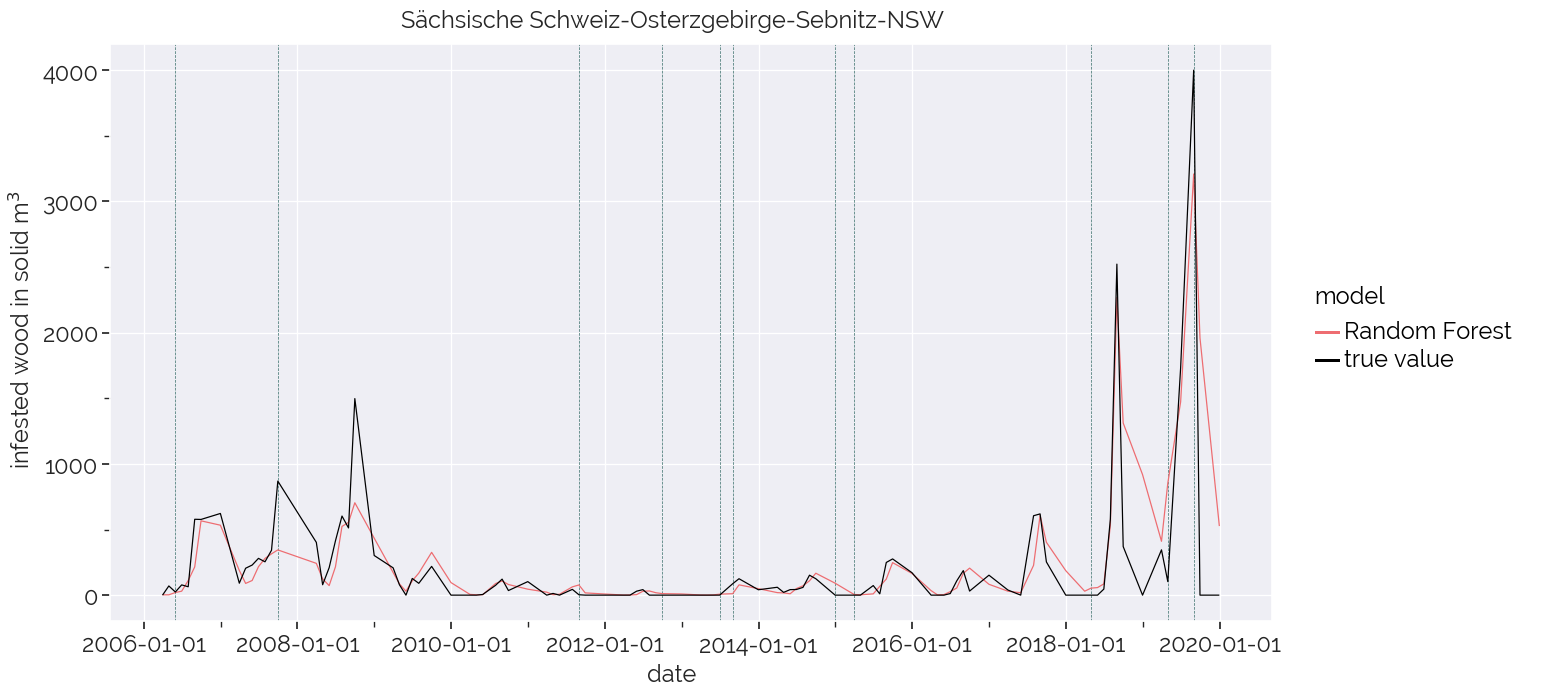

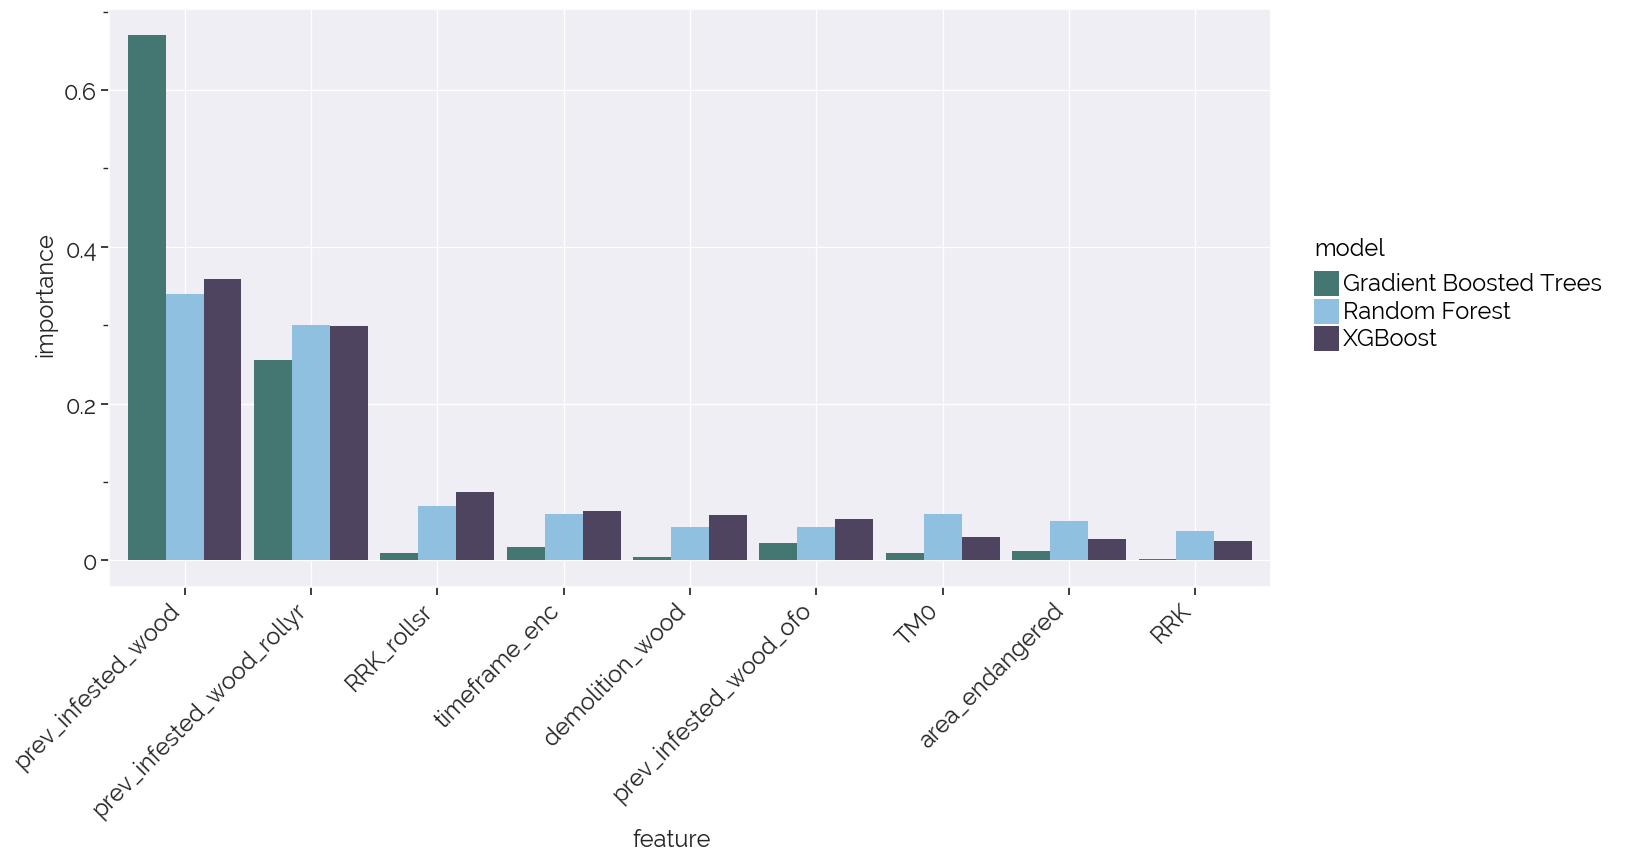

In [60]:
plot_results(fru_results_df, best_models_fru, grid_dict, X_train, X_val, 
             y_train, y_val, r'pred_frugal/')

Further improvements to virtually all regression models could be made compared to the liberal selection approach. Models with a smaller amount of carefully chosen features outperform the models with a large amount of features and PCA on the same training and validation data sets as well as an identical hyperparameter grid (apart from the PCA hyperparameter). The model with the smallest validation set MAE among them is a Random Forest regressor (MAE of 165.58 m$^3$ compared to the baseline of 288.15 m$^3$ for linear regression).

The quality of this regressors predictions compared to the true values is also rather impressive considering some of the problems discovered in the data during the EDA. However, while the validation set MAE is unquestionably lower than that of the best model of the liberal selection approach, in some cases the yearly peaks are not hit as reliably. This is for intstance apparent in the 'Vogtlandkreis-Zwönitz-NSW' ID for both models. The XGBoost of the liberal selection approach was able to predict the correct peak timeframes more often. A look at the feature importances reveals, that the frugal approach Random Forest is very reliant on the previous value for infested wood and the rolling sum of previously infested wood, making it very likely that the model is 'readjusting' after high target variable values it didn't predict while at the same time being worse at predicting them. This would make it risky to use the model for forecasts of multiple timeframes in a row, because errors would quickly add up and be at risk of running out of control in a feedback loop. The liberal model might do better in this case because of the PCA blending the previously infested wood with other features. In the other comparison plots the frugal Random Forest fares similarly in regard to the yearly fluctuations, making the 'Vogtlandkreis-Zwönitz-NSW' ID an isolated case among them.

# 6 Choosing the best model

Although the frugal Random Forest regressor had some small hickups regarding the predictions in one of the examined IDs, it is undeniably the model with the best validation set MAE by far. Therefor it is chosen as the best and final model of this project. Let's see the scores of the test set, which was kept under lock and key until now.

In [61]:
final_model = best_models_fru[1]

y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

print(f'\n\nSummary of test set errors')
print(f'Random Forest: frugal approach:')
print('-------------------------')

mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
ev = explained_variance_score(y_test, y_test_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Explained Variance: {ev:.2f}\n')



Summary of test set errors
Random Forest: frugal approach:
-------------------------
MAE: 141.82
RMSE: 911.83
Explained Variance: 0.62



In [62]:
fru_results_df['final model'] = np.concatenate(
    [y_train_pred, y_val_pred, y_test_pred]
)    

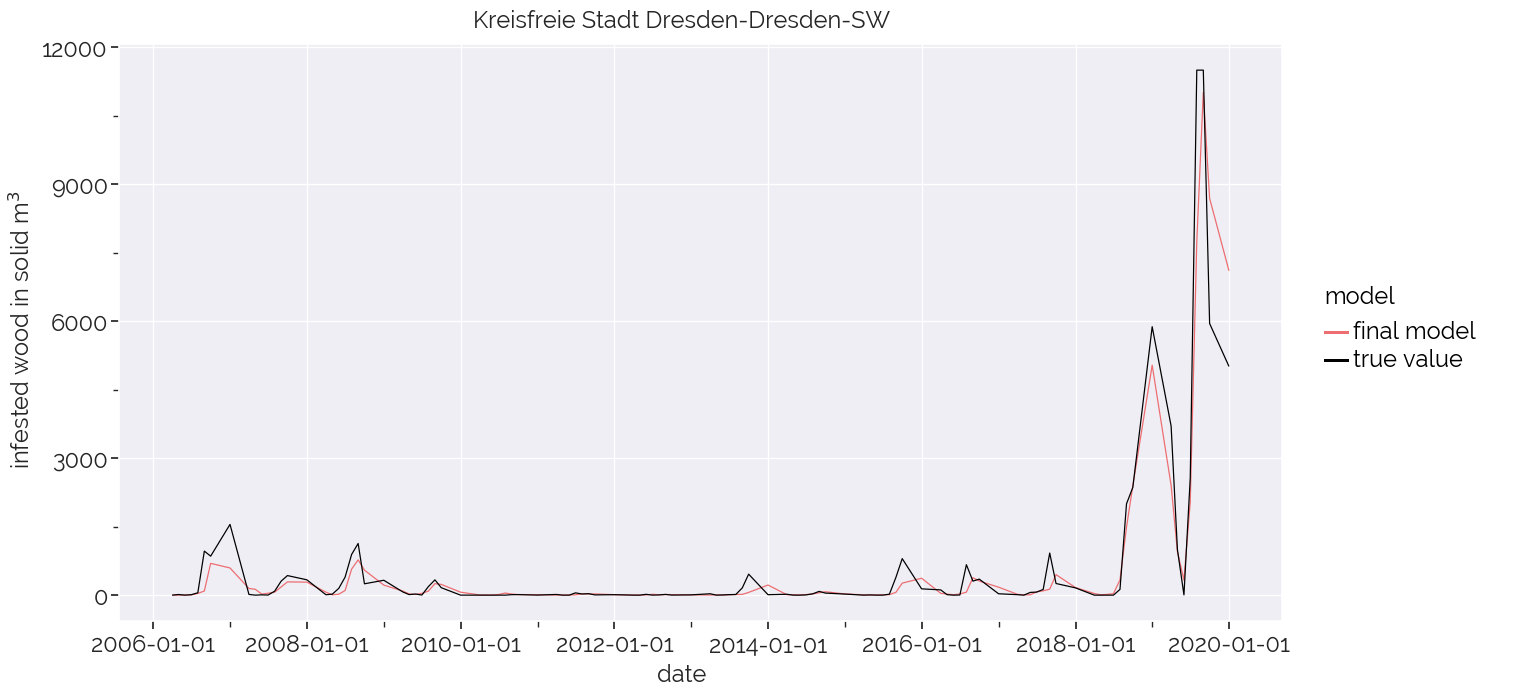

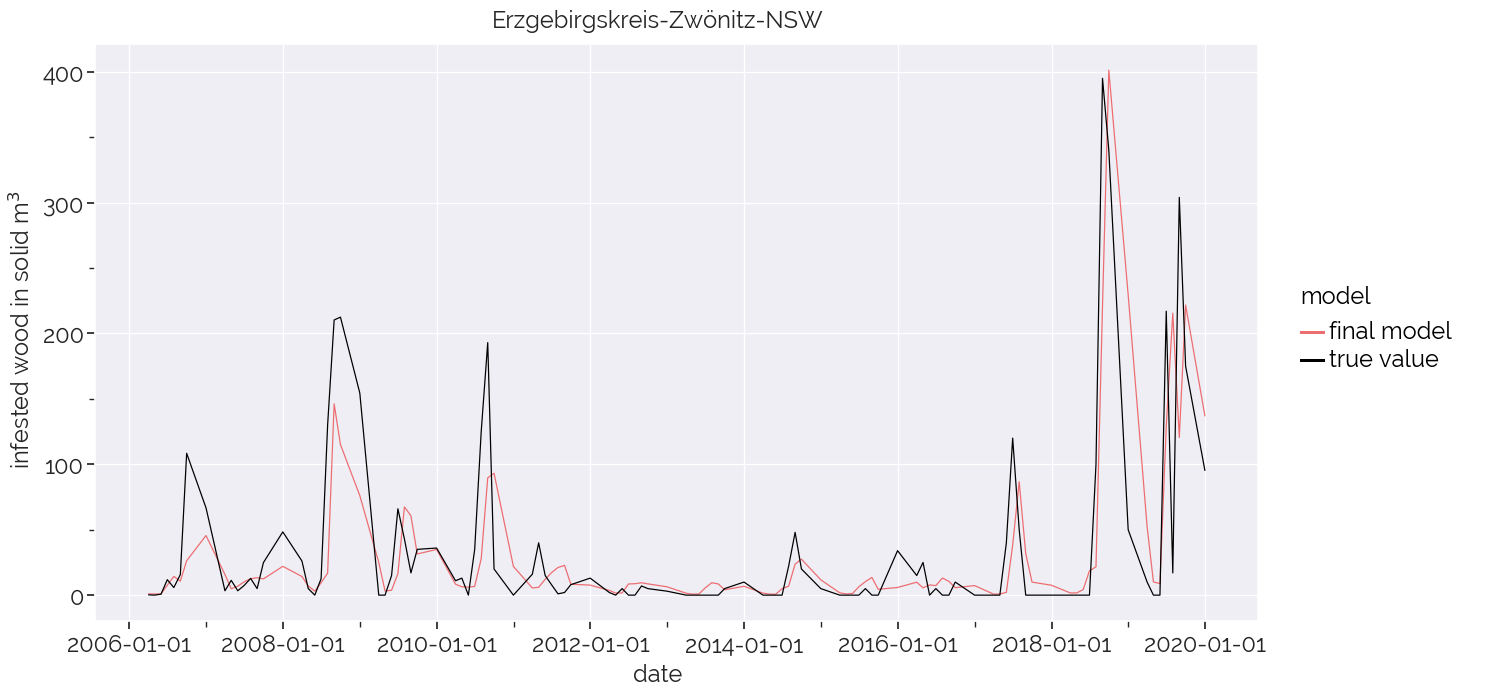

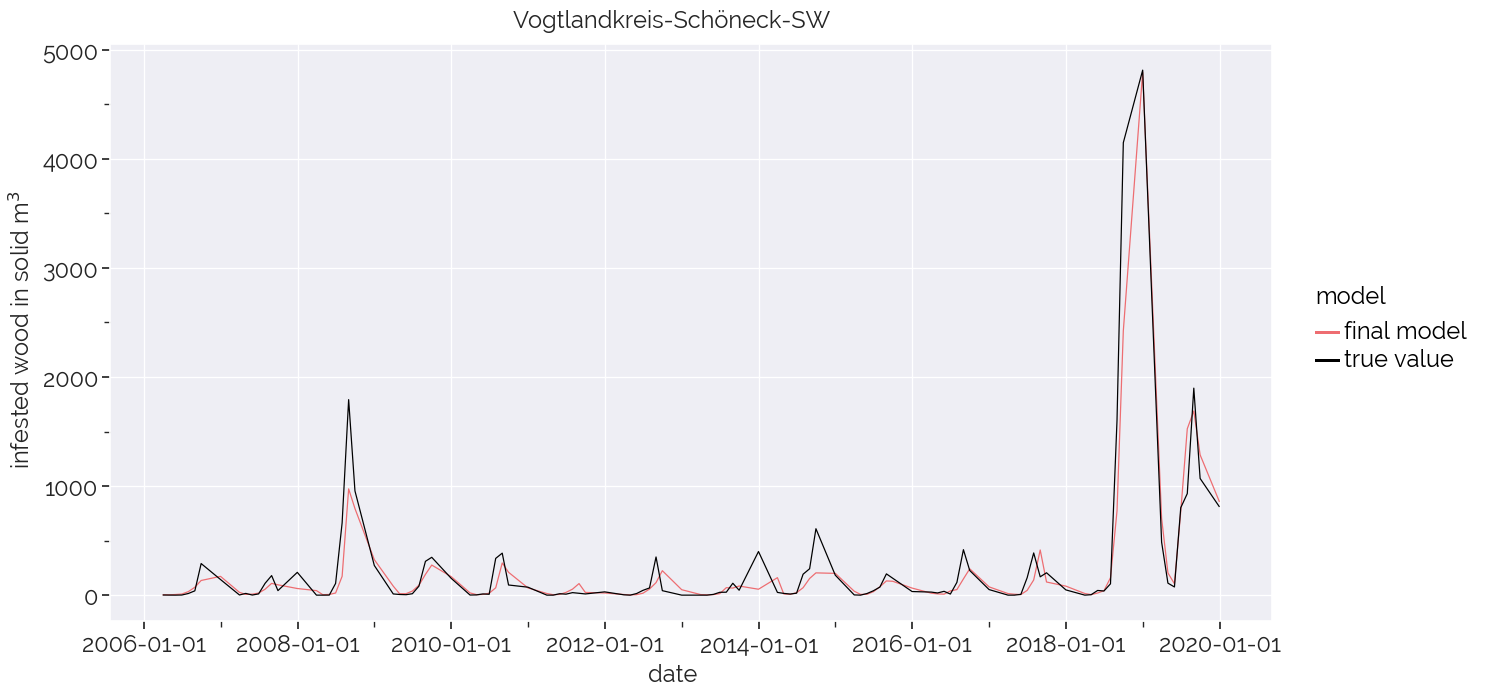

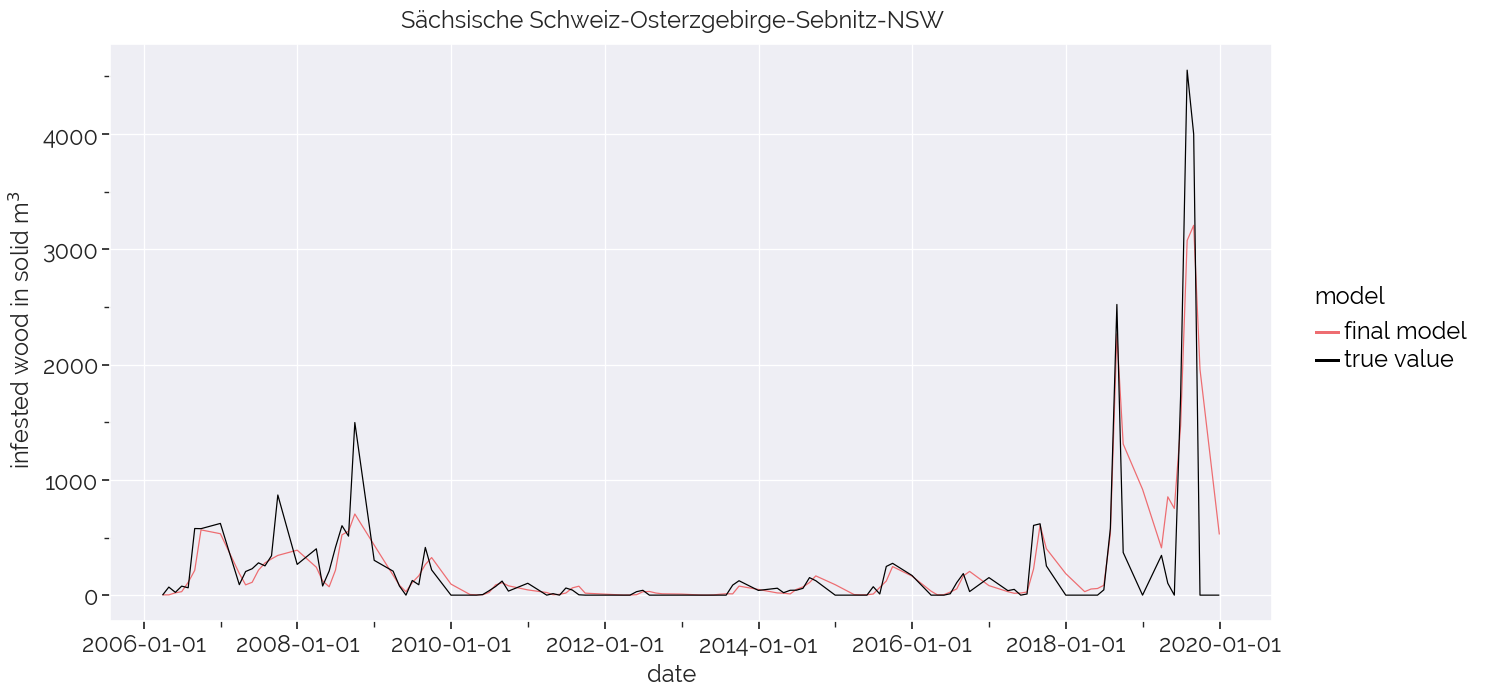

In [64]:
for ID in fru_results_df['id'].unique():
 
    draw = fru_results_df[fru_results_df['id'] == ID]
    
    draw = pd.melt(draw, id_vars=['id', 'timestamp', 'set'], 
                   value_vars=['true value', 'final model'])
    
    # include validation and test set timestamps
    validation_ts = draw[draw['set'] == 'validation set']['timestamp']
    test_ts = draw[draw['set'] == 'test set']['timestamp']
    
    # make plot
    p = (
        p9.ggplot(draw)
        + p9.geom_line(p9.aes('timestamp', 'value', color='variable'))
        + p9.scale_color_manual([mycolors[1],'black'], name='model')
        + p9.xlab('date') + p9.ylab(r'infested wood in solid m$^3$')
        + p9.labels.ggtitle(ID)
        + mythemewide
    )
    # save every plot
    p.save(fr'pred_final/{ID}.png', verbose=False)
    
    # only show specific plots
    if ID in [
        'Vogtlandkreis-Schöneck-SW',
        'Sächsische Schweiz-Osterzgebirge-Sebnitz-NSW',
        'Erzgebirgskreis-Zwönitz-NSW',
        'Kreisfreie Stadt Dresden-Dresden-SW'
    ]:
        p.draw()

Test set performance is even better than training and validation set performance, likely because a lesser number of values from critical years/forestry districts was allocated to this set. Overall it is expected that (for prediction of the next timeframe after actual observations are present - remember this is what the model was trained for) the model generalizes well. The predictions in many cases are more promising than what was anticipated by *Sachsenforst* and after the EDA. Some small concerns regarding the suitability of the model still exist, but those have to be reevaluated afterl predictions for 2021 are made and compared to the actual values. The deployment of the model will take place in the next notebook where it will be used to forecast infested wood values based on multiple, user-defined scenarios. Before the model can deployed it has to be saved by writing it to a file. 

In [65]:
# save the model to disk
pickle.dump(final_model, open('final_model.pkl', 'wb'))